# **EBook Price Classification**


*  Palida Yingwatchara 6338140021




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
from datetime import date
import time
import datetime

from bs4 import BeautifulSoup
import requests
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # basic plots
import seaborn as sns # advanced statistical plots

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn import impute
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
payload_path = '/content/drive/MyDrive/Colab Notebooks/BigDataMLProject/payload_data'

# Scrape Data

Scrape from 2000 Best Selling book at https://www.mebmarket.com/index.php?store=&action=book_list&condition=paid&page_no=1 at 06/04/2024

In [ ]:
url = "https://www.mebmarket.com/ajax.php"

In [ ]:
pl_df = pd.read_csv(payload_path)
payloads = pl_df['payloads'].to_list()

In [ ]:
headers = {
  'accept': '*/*',
  'accept-language': 'en-US,en;q=0.9',
  'cache-control': 'no-cache',
  'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
  'cookie': 'uvc=1; _ga=GA1.1.1062698488.1712344178; _gcl_au=1.1.1334323144.1712344178; _fbp=fb.1.1712344178004.727665135; PHPSESSID=t5abakhg97d7uk72j3jjob35qa; _mcnc=1; _ga_EMQJSNRDN4=GS1.1.1712371854.3.1.1712386493.23.0.0',
  'origin': 'https://www.mebmarket.com',
  'pragma': 'no-cache',
  'referer': 'https://www.mebmarket.com/index.php?store=all&action=book_list&condition=paid&page_no=1',
  'sec-ch-ua': '"Google Chrome";v="123", "Not:A-Brand";v="8", "Chromium";v="123"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"',
  'sec-fetch-dest': 'empty',
  'sec-fetch-mode': 'cors',
  'sec-fetch-site': 'same-origin',
  'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
  'x-requested-with': 'XMLHttpRequest'
}

datalist = []
for payload in payloads:
  response = requests.request("POST", url, headers=headers, data=payload)
  data = response.json()['data']['book_list']
  datalist.append(data)

In [ ]:
books = []
for data in datalist:
  for book in data:
    books.append(book)

In [ ]:
df = pd.DataFrame(books)
df = df.drop_duplicates(subset=['book_id'], keep='first').reset_index(drop=True)
df.tail()

,book_id,book_publisher,category_id,category_name,book_name,book_author,book_cover_price,book_baht_price,book_dollar_price,book_t1c_price,...,promotion_price_t1c_after_quota,award_name,award_desc,book_duration,sample_duration,user_id_narrator,narrator_name,is_completed,issue_count,render_as_group
1995,285879,บริษัท เกมฟิกส์ จำกัด,196,นิตยสารการ์ตูนและเกม,บทสรุปเกม The Legend of Zelda: Breath of the W...,GameFixs,580.00,149.00,3.99,1192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,266672,Bongkoch Publishing,12,การ์ตูนผู้หญิง,ร้อยเรียงรักจากหัวใจ 7 ฉบับพิเศษ + การ์ตูนเล่ม...,suu Morishita,179.00,120.00,3.99,960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,13299,นันทินี,5,นิยายโรมานซ์,ลับแลพิศวาส,นันทินี,295.00,219.00,7.99,1752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,293760,NanaNaRiS Books,54,นิยายวาย Boy Love / Yaoi,เมื่อซูเปอร์สตาร์กลายเป็นเต่าน้อย,Nueng.Phd,420.00,378.00,10.99,3024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,288032,Paris Is Raining,54,นิยายวาย Boy Love / Yaoi,ภริยาอำนวยพร,Paris Is Raining,389.00,299.00,9.99,2392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.to_csv('raw_meb_book_data', index=False)

# Explore Data

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/BigDataMLProject/raw_meb_book_data'

In [ ]:
raw_df = pd.read_csv(data_path)

In [ ]:
raw_df.head()

,book_id,book_publisher,category_id,category_name,book_name,book_author,book_cover_price,book_baht_price,book_dollar_price,book_t1c_price,...,promotion_price_t1c_after_quota,award_name,award_desc,book_duration,sample_duration,user_id_narrator,narrator_name,is_completed,issue_count,render_as_group
0,291934,The Shepherd,5,นิยายโรมานซ์,WIP #พี่วิปคือพระเอก,The Shepherd,600.00,369.00,10.99,2952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,292108,บัวบูรพา,21,นิยายรัก,เลิกรักไปได้ก็ดี,บัวบูรพา,350.00,199.00,6.99,1592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26011,T&amp;M,51,นิยาย Girl Love/Yuri,ใจซ่อนรัก,มีนาม,380.00,220.00,7.99,1760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,292701,หลิ่งชิง,228,นิยายรักจีนโบราณ,รักจนไม่อาจปล่อยนาง,หลิ่งชิง,319.00,169.00,5.99,1352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,290827,สถาพรบุ๊คส์,228,นิยายรักจีนโบราณ,อุบายนางหงส์,มนต์มิถุนา,400.00,260.00,8.99,2080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
raw_df.shape

(2000, 59)

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 59 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   book_id                             2000 non-null   int64  
 1   book_publisher                      2000 non-null   object 
 2   category_id                         2000 non-null   int64  
 3   category_name                       2000 non-null   object 
 4   book_name                           2000 non-null   object 
 5   book_author                         2000 non-null   object 
 6   book_cover_price                    2000 non-null   float64
 7   book_baht_price                     2000 non-null   float64
 8   book_dollar_price                   2000 non-null   float64
 9   book_t1c_price                      2000 non-null   int64  
 10  book_ratings                        2000 non-null   float64
 11  file_type                           2000 no

In [ ]:
#Check missing values
missing_val = (raw_df.isnull().sum()*100/len(raw_df)).sort_values(ascending=False)
print('------- Percentage of missing value -------')
print(missing_val[(missing_val > 0)])

------- Percentage of missing value -------
subs_id                              100.00
subs_name                            100.00
render_as_group                       99.95
issue_count                           99.95
is_completed                          99.95
award_desc                            99.55
narrator_name                         99.45
user_id_narrator                      99.45
sample_duration                       99.45
book_duration                         99.45
award_name                            99.45
movie_name                            97.15
movie_desc                            97.05
movie_type_list                       96.55
package_book_id                       96.20
promotion_price_dollar_after_quota    88.30
promotion_price_t1c_after_quota       88.30
promotion_price_baht_after_quota      87.40
original_price_dollar                 84.90
promotion_price_dollar                84.90
quota_max_order_success               84.80
promotion_price_baht            

In [ ]:
# Drop column that has more than 70% missing values
columns_to_drop = missing_val[missing_val > 70].index.tolist()
df_1 = raw_df.drop(columns = columns_to_drop)
print('------ Drop Columns (missing more than 70%)-------')
print()
print(columns_to_drop)

------ Drop Columns (missing more than 70%)-------

['subs_id', 'subs_name', 'render_as_group', 'issue_count', 'is_completed', 'award_desc', 'narrator_name', 'user_id_narrator', 'sample_duration', 'book_duration', 'award_name', 'movie_name', 'movie_desc', 'movie_type_list', 'package_book_id', 'promotion_price_dollar_after_quota', 'promotion_price_t1c_after_quota', 'promotion_price_baht_after_quota', 'original_price_dollar', 'promotion_price_dollar', 'quota_max_order_success', 'promotion_price_baht', 'quota_used_order_success', 'original_price_baht']


In [ ]:
# Explore data
df_1['book_thumbnail_path']

0       https://cdn-local.mebmarket.com/meb/server1/29...
1       https://cdn-local.mebmarket.com/meb/server1/29...
2       https://cdn-local.mebmarket.com/meb/server1/26...
3       https://cdn-local.mebmarket.com/meb/server1/29...
4       https://cdn-local.mebmarket.com/meb/server1/29...
                              ...                        
1995    https://cdn-local.mebmarket.com/meb/server1/23...
1996    https://cdn-local.mebmarket.com/meb/server1/23...
1997    https://cdn-local.mebmarket.com/meb/server1/29...
1998    https://cdn-local.mebmarket.com/meb/server1/13...
1999    https://cdn-local.mebmarket.com/meb/server1/29...
Name: book_thumbnail_path, Length: 2000, dtype: object

In [ ]:
df_1[['book_publisher','user_id_publisher']].nunique()

book_publisher       656
user_id_publisher    656
dtype: int64

In [ ]:
df_1[['book_publisher','user_id_publisher']].sort_values('book_publisher')

,book_publisher,user_id_publisher
67,suniki,4811705
309,++saisioo++,613566
368,++saisioo++,613566
1912,++saisioo++,613566
977,++saisioo++,613566
...,...,...
1414,白玦_ไป๋เจวี๋ย,5360438
429,白玦_ไป๋เจวี๋ย,5360438
950,白玦_ไป๋เจวี๋ย,5360438
467,白玦_ไป๋เจวี๋ย,5360438


In [ ]:
df_1[['series_id','series_name']].nunique()

series_id      544
series_name    544
dtype: int64

In [ ]:
df_1[['series_id','series_name']].sort_values('series_id').drop_duplicates()

,series_id,series_name
1712,48.00,หงสาจอมราชันย์
1626,61.00,การิน ปริศนาคดีอาถรรพ์ (การ์ตูน)
194,304.00,การิน ปริศนาคดีอาถรรพ์
159,464.00,ปฐพีไร้พ่าย
146,499.00,DRAGON BALL ดราก้อนบอล
...,...,...
95,"17,101.00",ข้าผู้นี้ขอตัดสิ้นวาสนา
1234,"17,109.00",top spender #ฮอตเนิร์ดเฮิร์ตนอท
91,"17,113.00",เมียหมอขอหย่า
1072,"17,118.00",ถนนทุกสายไม่ได้มุ่งสู่วันสิ้นโลก


In [ ]:
df_1[['category_id','category_name']].nunique()

category_id      45
category_name    45
dtype: int64

In [ ]:
df_1[['category_id','category_name']].sort_values('category_id').drop_duplicates()

,category_id,category_name
233,3,นิยายกำลังภายใน
1576,4,นิยายแฟนตาซี
1505,5,นิยายโรมานซ์
621,6,วรรณกรรมเยาวชน
620,7,ชีวประวัติ
1744,8,วิทยาศาสตร์และเทคโนโลยี
1179,9,สาระบันเทิง
605,12,การ์ตูนผู้หญิง
1060,15,พัฒนาตนเอง
401,16,วรรณกรรมทั่วไป


In [ ]:
df_1[['promotion_end_date', 'promotion_end_datetime','promotion_benefit_type_list' ]].isna().sum()

promotion_end_date             717
promotion_end_datetime         717
promotion_benefit_type_list    717
dtype: int64

In [ ]:
df_1[['promotion_end_date', 'promotion_end_datetime','promotion_benefit_type_list']]

,promotion_end_date,promotion_end_datetime,promotion_benefit_type_list
0,NaN,NaN,NaN
1,2024-04-15,2024-04-15 23:59:59,['1']
2,2024-04-16,2024-04-16 23:59:59,['1']
3,2024-04-19,2024-04-19 23:59:59,['1']
4,2024-04-16,2024-04-16 23:59:59,['1']
...,...,...,...
1995,NaN,NaN,NaN
1996,NaN,NaN,NaN
1997,2024-04-20,2024-04-20 23:59:00,['1']
1998,2024-04-16,2024-04-16 23:59:59,['1']


In [ ]:
print(df_1['has_subs_package'].value_counts(ascending=False), '\n', '-------------------')
print(df_1['not_sell_in_apple'].value_counts(ascending=False), '\n', '-------------------')
print(df_1['group_in_store'].value_counts(ascending=False), '\n', '-------------------')
print(df_1['is_shop_campaign'].value_counts(ascending=False), '\n', '-------------------')

has_subs_package
0    2000
Name: count, dtype: int64 
 -------------------
not_sell_in_apple
0    2000
Name: count, dtype: int64 
 -------------------
group_in_store
0    2000
Name: count, dtype: int64 
 -------------------
is_shop_campaign
0    2000
Name: count, dtype: int64 
 -------------------


In [ ]:
# Explore
df_1[['book_cover_price', 'book_baht_price', 'book_dollar_price', 'book_ratings', 'book_t1c_price']]

,book_cover_price,book_baht_price,book_dollar_price,book_ratings,book_t1c_price
0,600.00,369.00,10.99,4.99,2952
1,350.00,199.00,6.99,4.88,1592
2,380.00,220.00,7.99,4.93,1760
3,319.00,169.00,5.99,4.98,1352
4,400.00,260.00,8.99,4.96,2080
...,...,...,...,...,...
1995,160.00,149.00,3.99,4.33,1192
1996,125.00,100.00,3.99,4.87,800
1997,129.00,69.00,1.99,0.00,552
1998,355.00,248.00,6.99,4.96,1984


In [ ]:
# Drop columns that has same meaning as other columns, columns that has only single value etc.
# book_id : pk,
columns_to_drop_2 = ['book_id','book_name','user_id_publisher','series_id', 'category_id', 'series_issue_id',
                     'promotion_end_datetime','promotion_benefit_type_list', 'sort_key',
                     'has_subs_package','not_sell_in_apple', 'flexible_pricing_description',
                     'group_in_store', 'is_shop_campaign', 'book_thumbnail_path','file_type',
                     'book_dollar_price', 'book_t1c_price']
df_2 = df_1.drop(columns = columns_to_drop_2 ,axis=1)

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   book_publisher           2000 non-null   object 
 1   category_name            2000 non-null   object 
 2   book_author              2000 non-null   object 
 3   book_cover_price         2000 non-null   float64
 4   book_baht_price          2000 non-null   float64
 5   book_ratings             2000 non-null   float64
 6   has_struct               2000 non-null   int64  
 7   rating_count             2000 non-null   int64  
 8   hall_movie               2000 non-null   int64  
 9   hall_award               2000 non-null   int64  
 10  hall_bestseller          2000 non-null   int64  
 11  thumbnail_edition        2000 non-null   int64  
 12  adult_only               2000 non-null   int64  
 13  flexible_pricing_enable  2000 non-null   int64  
 14  content_type            

In [ ]:
df_2['thumbnail_edition']

0        5
1        2
2       10
3        7
4        2
        ..
1995     2
1996     2
1997     2
1998     3
1999     2
Name: thumbnail_edition, Length: 2000, dtype: int64

In [ ]:
df_2['flexible_pricing_enable']

0       1
1       1
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    0
1998    0
1999    1
Name: flexible_pricing_enable, Length: 2000, dtype: int64

In [ ]:
df_2.head()

,book_publisher,category_name,book_author,book_cover_price,book_baht_price,book_ratings,has_struct,rating_count,hall_movie,hall_award,hall_bestseller,thumbnail_edition,adult_only,flexible_pricing_enable,content_type,series_name,promotion_end_date
0,The Shepherd,นิยายโรมานซ์,The Shepherd,600.00,369.00,4.99,0,362,0,0,1,5,1,1,book,MVP,NaN
1,บัวบูรพา,นิยายรัก,บัวบูรพา,350.00,199.00,4.88,0,162,0,0,1,2,0,1,book,NaN,2024-04-15
2,T&amp;M,นิยาย Girl Love/Yuri,มีนาม,380.00,220.00,4.93,0,367,1,0,1,10,0,0,book,NaN,2024-04-16
3,หลิ่งชิง,นิยายรักจีนโบราณ,หลิ่งชิง,319.00,169.00,4.98,0,192,0,0,1,7,0,0,book,NaN,2024-04-19
4,สถาพรบุ๊คส์,นิยายรักจีนโบราณ,มนต์มิถุนา,400.00,260.00,4.96,0,53,0,0,0,2,0,0,book,NaN,2024-04-16


In [ ]:
df_2[df_2['series_name'].notna()]['series_name'].sample(20)

1494                           ซาซากิกับพีจัง (ฉบับนิยาย)
748                       ผมไม่เป็น (โอเมก้า) ของคุณหรอก!
668                 พลิกลิขิตฟ้า เปลี่ยนชะตาก่อนถูกเนรเทศ
114               เจ้าสาวหิมะมือใหม่ อยากหลอมรวมใจไปกับผม
585                      คุณคุโบะไม่ยอมให้ผมเป็นตัวประกอบ
1401                     คุณคุโบะไม่ยอมให้ผมเป็นตัวประกอบ
1993                                       สัญญาณเตือนตาย
284                                             มาโปรดรัก
27                         Blank เติมคำว่ารักลงในช่องว่าง
34                   กลายเป็นพี่เลี้ยงเด็กในนิทานสายดาร์ก
330     ผมที่ไม่อยากทำงานไปชั่วชีวิต ได้สนิทสนมกับไอดอ...
1308                                          ปรปักษ์จำนน
808                                                 ๙สิ่ง
841                        คำอธิษฐานในวันที่จากลา FRIEREN
1737                                    ม่านฝันบ่วงวสันต์
1042           [นิยายแปล] ว่าด้วยจุดจบของการไปช่วยตัวร้าย
163                                The Master of Witharia
1841          

In [ ]:
df_2.iloc[708, :]

book_publisher                       DarkQueenLiLith
category_name               นิยายวาย Boy Love / Yaoi
book_author                          DarkQueenLiLith
book_cover_price                              650.00
book_baht_price                               269.00
book_ratings                                    4.76
has_struct                                         0
rating_count                                      71
hall_movie                                         0
hall_award                                         0
hall_bestseller                                    1
thumbnail_edition                                 19
adult_only                                         1
flexible_pricing_enable                            1
content_type                                    book
series_name                Elf Slave ปีศาจ ทาส เอลฟ์
promotion_end_date                        2024-04-16
Name: 708, dtype: object

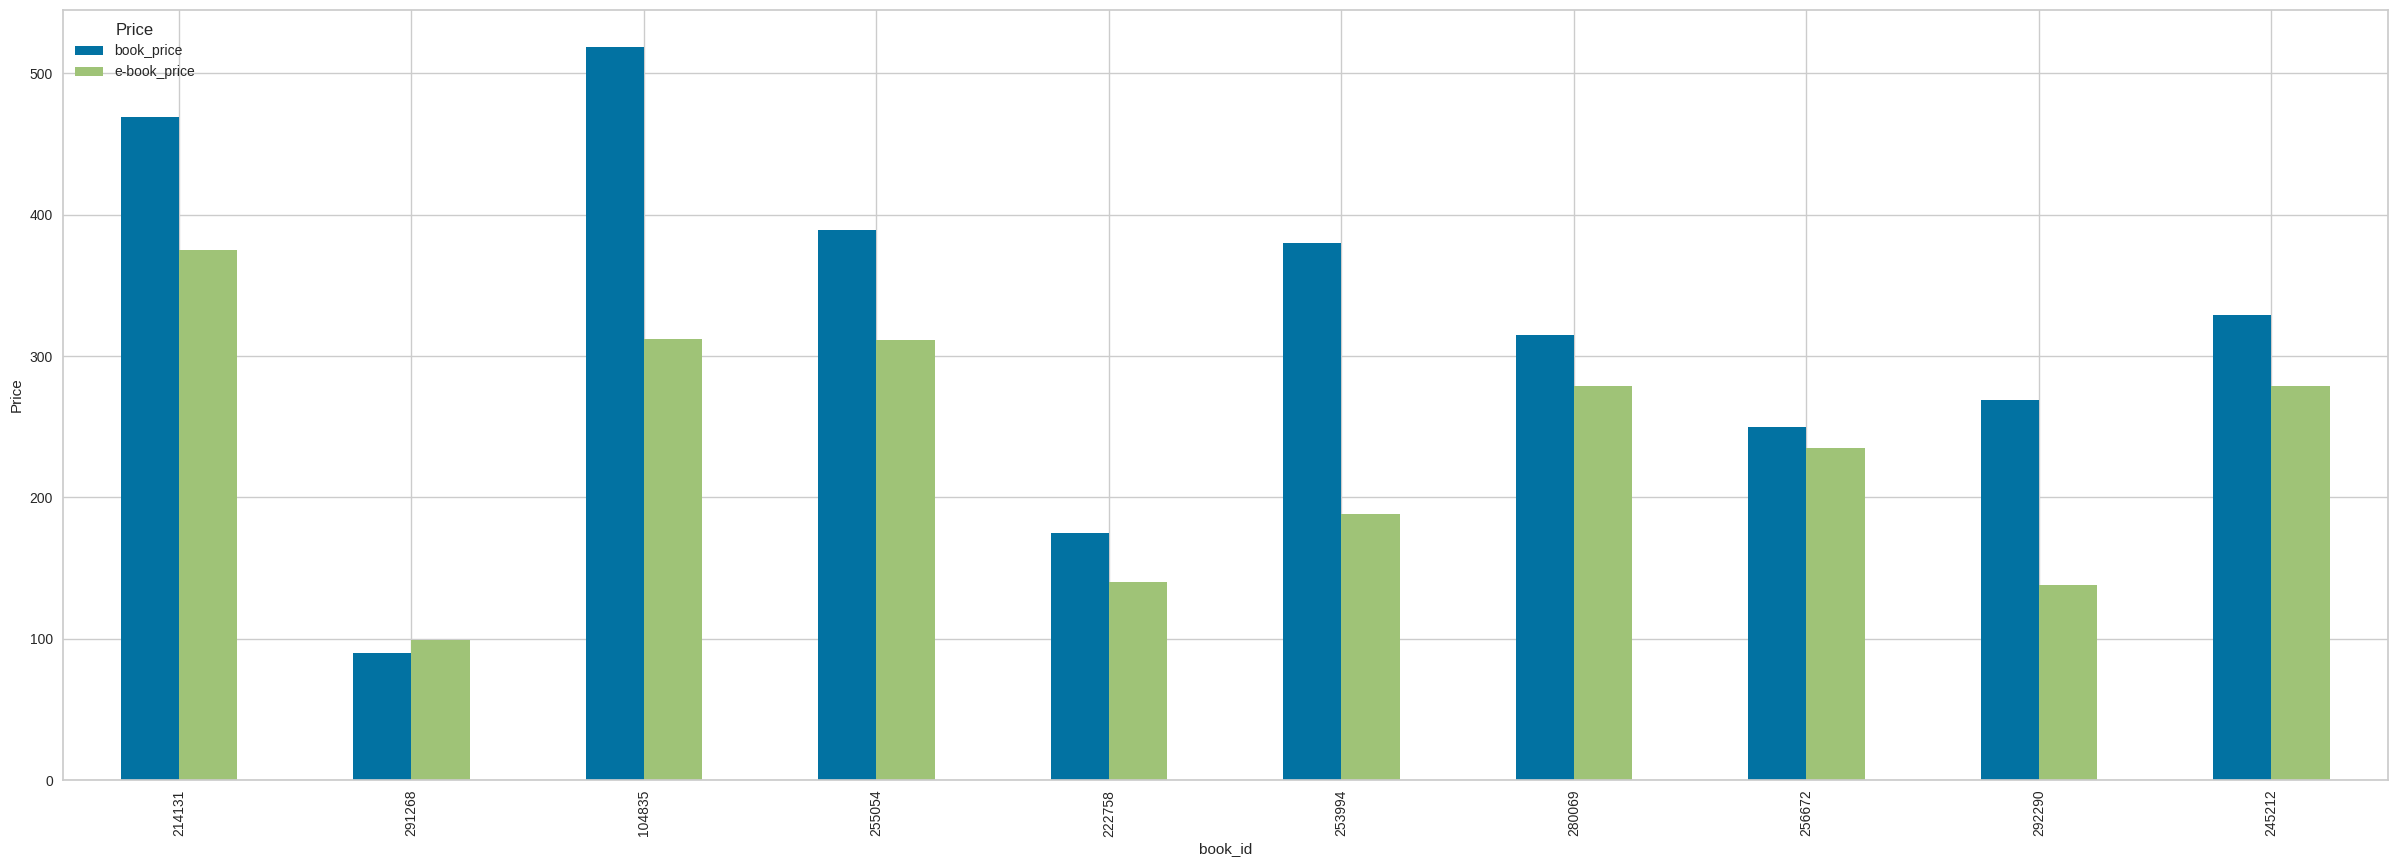

In [ ]:
raw_df.sample(10).plot(x ='book_id',y=["book_cover_price", "book_baht_price"],
        kind="bar", figsize=(30, 10))
plt.legend(title='Price', loc='upper left', labels=['book_price', 'e-book_price'])
plt.ylabel("Price")
plt.show()

In [ ]:
raw_df['percent_increase'] = ((raw_df['book_cover_price'] - raw_df['book_baht_price']) / raw_df['book_baht_price']) * 100

print(f"The average percent increase from ebook to book price is {raw_df['percent_increase'].mean():.2f}%")


The average percent increase from ebook to book price is 49.96%


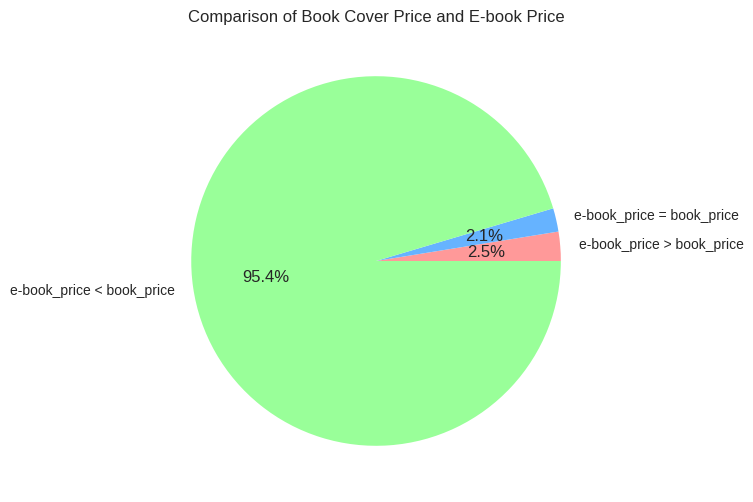

In [ ]:
# Comparison of Book Cover Price and E-book Price
less_than_ebook_price = (raw_df['book_cover_price']< raw_df['book_baht_price']).sum()
equal_ebook_price = (raw_df['book_cover_price'] == raw_df['book_baht_price']).sum()
more_than_ebook_price = (raw_df['book_cover_price'] > raw_df['book_baht_price']).sum()

labels = ['e-book_price > book_price', 'e-book_price = book_price', 'e-book_price < book_price']
sizes = [less_than_ebook_price, equal_ebook_price, more_than_ebook_price]
colors = ['#ff9999','#66b3ff','#99ff99']
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Comparison of Book Cover Price and E-book Price')
#plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Preprocessing

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   book_publisher           2000 non-null   object 
 1   category_name            2000 non-null   object 
 2   book_author              2000 non-null   object 
 3   book_cover_price         2000 non-null   float64
 4   book_baht_price          2000 non-null   float64
 5   book_ratings             2000 non-null   float64
 6   has_struct               2000 non-null   int64  
 7   rating_count             2000 non-null   int64  
 8   hall_movie               2000 non-null   int64  
 9   hall_award               2000 non-null   int64  
 10  hall_bestseller          2000 non-null   int64  
 11  thumbnail_edition        2000 non-null   int64  
 12  adult_only               2000 non-null   int64  
 13  flexible_pricing_enable  2000 non-null   int64  
 14  content_type            

In [ ]:
# cast type
df_2['promotion_end_date'] = pd.to_datetime(df_2['promotion_end_date'])

In [ ]:
# Change data to be catagorical
df_2['has_series'] = df_2['series_name'].apply(lambda x: 0 if pd.isna(x) else 1)
df_2['has_promotion'] = df_2['promotion_end_date'].apply(lambda x: 0 if pd.isna(x) else 1)
df_2['days_bf_promotion_end'] = df_2['promotion_end_date'].apply(lambda x: 0 if pd.isna(x) else (x -pd.Timestamp(date(2024, 4, 6))).days)
# drop column
df_3 = df_2.drop(columns =['series_name', 'promotion_end_date'] ,axis=1)

In [ ]:
df_3.head()

,book_publisher,category_name,book_author,book_cover_price,book_baht_price,book_ratings,has_struct,rating_count,hall_movie,hall_award,hall_bestseller,thumbnail_edition,adult_only,flexible_pricing_enable,content_type,has_series,has_promotion,days_bf_promotion_end
0,The Shepherd,นิยายโรมานซ์,The Shepherd,600.00,369.00,4.99,0,362,0,0,1,5,1,1,book,1,0,0
1,บัวบูรพา,นิยายรัก,บัวบูรพา,350.00,199.00,4.88,0,162,0,0,1,2,0,1,book,0,1,9
2,T&amp;M,นิยาย Girl Love/Yuri,มีนาม,380.00,220.00,4.93,0,367,1,0,1,10,0,0,book,0,1,10
3,หลิ่งชิง,นิยายรักจีนโบราณ,หลิ่งชิง,319.00,169.00,4.98,0,192,0,0,1,7,0,0,book,0,1,13
4,สถาพรบุ๊คส์,นิยายรักจีนโบราณ,มนต์มิถุนา,400.00,260.00,4.96,0,53,0,0,0,2,0,0,book,0,1,10


In [ ]:
numerical_cols = df_3.select_dtypes(include=['float64']).columns.tolist()
numerical_cols

['book_cover_price', 'book_baht_price', 'book_ratings']

In [ ]:
categorical_cols = df_3.select_dtypes(include=['int64','object']).columns.tolist()
categorical_cols

['book_publisher',
 'category_name',
 'book_author',
 'has_struct',
 'rating_count',
 'hall_movie',
 'hall_award',
 'hall_bestseller',
 'thumbnail_edition',
 'adult_only',
 'flexible_pricing_enable',
 'content_type',
 'has_series',
 'has_promotion',
 'days_bf_promotion_end']

In [ ]:
numerical_cols.extend(['rating_count', 'thumbnail_edition', 'days_bf_promotion_end'])
numerical_features = list(set(numerical_cols)-set(['book_baht_price']))

print('numerical cols: \n',numerical_cols)
print()
print('numerical features: \n', numerical_features)
print('len numerical_features:', len(numerical_features))

numerical cols: 
 ['book_cover_price', 'book_baht_price', 'book_ratings', 'rating_count', 'thumbnail_edition', 'days_bf_promotion_end']

numerical features: 
 ['thumbnail_edition', 'rating_count', 'days_bf_promotion_end', 'book_ratings', 'book_cover_price']
len numerical_features: 5


In [ ]:
categorical_cols =  list(set(categorical_cols)-set(['rating_count', 'thumbnail_edition','series_name','promotion_end_date', 'days_bf_promotion_end']))
categorical_features = categorical_cols


print('categorical_cols: \n', categorical_cols)
print()
print('categorical features: \n', categorical_features)
print('len categorical_features:', len(categorical_features))

categorical_cols: 
 ['adult_only', 'hall_award', 'flexible_pricing_enable', 'category_name', 'has_struct', 'book_author', 'book_publisher', 'hall_bestseller', 'content_type', 'has_series', 'has_promotion', 'hall_movie']

categorical features: 
 ['adult_only', 'hall_award', 'flexible_pricing_enable', 'category_name', 'has_struct', 'book_author', 'book_publisher', 'hall_bestseller', 'content_type', 'has_series', 'has_promotion', 'hall_movie']
len categorical_features: 12


In [ ]:
df_3['book_baht_price'].quantile(q=[0.4,0.5,0.6])

0.40   195.00
0.50   224.00
0.60   255.00
Name: book_baht_price, dtype: float64

In [ ]:
df_3['book_price_cut'] = df_2['book_baht_price'].apply(lambda x:0 if x<=195.0 else(1 if x>=255.0 else 'middle'))

In [ ]:
df_3['book_price_cut'].value_counts()

book_price_cut
0         808
1         807
middle    385
Name: count, dtype: int64

In [ ]:
df = df_3.drop(df_3[df_3['book_price_cut']=='middle'].index)
df['book_price_cut'] = df['book_price_cut'].astype(int)
df['book_price_cut'].value_counts()

book_price_cut
0    808
1    807
Name: count, dtype: int64

In [ ]:
df.shape

(1615, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   book_publisher           1615 non-null   object 
 1   category_name            1615 non-null   object 
 2   book_author              1615 non-null   object 
 3   book_cover_price         1615 non-null   float64
 4   book_baht_price          1615 non-null   float64
 5   book_ratings             1615 non-null   float64
 6   has_struct               1615 non-null   int64  
 7   rating_count             1615 non-null   int64  
 8   hall_movie               1615 non-null   int64  
 9   hall_award               1615 non-null   int64  
 10  hall_bestseller          1615 non-null   int64  
 11  thumbnail_edition        1615 non-null   int64  
 12  adult_only               1615 non-null   int64  
 13  flexible_pricing_enable  1615 non-null   int64  
 14  content_type             1615

In [ ]:
X = df.drop(columns= ['book_baht_price', 'book_price_cut'], axis =1)
y = df['book_price_cut'].to_numpy()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3,shuffle=True, stratify=y ,random_state=100)

In [ ]:
X_train.head()

,book_publisher,category_name,book_author,book_cover_price,book_ratings,has_struct,rating_count,hall_movie,hall_award,hall_bestseller,thumbnail_edition,adult_only,flexible_pricing_enable,content_type,has_series,has_promotion,days_bf_promotion_end
710,เจ้าหญิงเม็ดทราย,นิยายรักจีนโบราณ,หย่งเอ๋อร์,329.00,4.43,0,7,0,0,0,2,0,1,book,0,1,15
1891,LUCKPIM Publishing,การ์ตูนทั่วไป,นัตสึ ฮิวงะ /Minoji KURATA /Touko SHINO,125.00,4.43,0,7,0,0,1,2,0,0,book,1,0,0
910,Amarin How to,พัฒนาตนเอง,นะโอะยุกิ ฮนดะ/กมลวรรณ เพ็ญอร่าม,225.00,4.55,0,11,0,0,1,6,0,0,book,0,1,10
175,PHOENIX,ไลท์โนเวล,คินุงาสะ โชโงะ,315.00,4.99,0,159,0,0,1,5,0,0,book,1,0,0
72,Rose by Amarin,นิยายวาย Boy Love / Yaoi,สามหนึ่งสองหนึ่ง,345.00,5.00,0,12,0,0,1,2,0,0,book,1,1,10


In [ ]:
X_train.shape

(1130, 17)

# Categorical -> Binary

In [ ]:
book_publisher_list =  df['book_publisher'].value_counts(ascending=False).head(5).index.tolist()
category_name_list = df['category_name'].value_counts(ascending=False).index.tolist()
book_author_list   = df['book_author'].value_counts(ascending=False).head(5).index.tolist()
content_type_list = df['content_type'].value_counts(ascending=False).head().index.tolist()

print('book_publisher_list : ', book_publisher_list)
print('category_name_list : ', category_name_list)
print('book_author_list : ', book_author_list)
print('content_type_list : ', content_type_list)

book_publisher_list :  ['PHOENIX', 'Siam Inter Comics', 'LUCKPIM Publishing', 'Amarin How to', 'First Page Pro.']
category_name_list :  ['นิยายวาย Boy Love / Yaoi', 'การ์ตูนทั่วไป', 'นิยายรักจีนโบราณ', 'นิยายรัก', 'นิยายโรมานซ์', 'การ์ตูน Boy Love / Yaoi', 'ไลท์โนเวล', 'นิยายแฟนตาซี', 'นิยาย Girl Love/Yuri', 'พัฒนาตนเอง', 'นิยายสืบสวนสอบสวน/ทริลเลอร์', 'นิยายรักวัยรุ่น', 'นิยายชีวิต/ดรามา', 'การ์ตูน Girl Love / Yuri', 'วรรณกรรมทั่วไป', 'การเงินการลงทุน', 'การ์ตูนผู้หญิง', 'นิยายลึกลับ/เขย่าขวัญ', 'จิตวิทยา', 'การ์ตูนเด็ก/การ์ตูนความรู้', 'ประวัติศาสตร์', 'การศึกษา/ตำราเรียน', 'นิยายผจญภัย/บู๊แอกชัน', 'นิยายกำลังภายใน', 'วิทยาศาสตร์และเทคโนโลยี', 'วรรณกรรมเยาวชน', 'ภาษา', 'รวมเรื่องสั้น', 'ความรู้ทั่วไป', 'คอมพิวเตอร์', 'สุขภาพ', 'สารคดี', 'นิยายไซไฟ', 'นิยายเสียดสีสังคม', 'การบริหารงานบุคคล', 'การเมือง/รัฐศาสตร์', 'การออกแบบและสร้างสรรค์', 'ชีวประวัติ', 'สาระบันเทิง', 'การตลาดและการบัญชี', 'บริหารจัดการ', 'เศรษฐศาสตร์และธุรกิจ', 'กฎหมาย']
book_author_list :  ['sing N song/8 hours', 'เจ

In [ ]:
def onehot_encode(df, category_list, col_name):
  onehot = OneHotEncoder(handle_unknown='ignore', categories = [category_list], dtype= np.int64)
  df_oh = pd.DataFrame(onehot.fit_transform(df[[col_name]]).toarray(), columns = category_list)
  return df_oh

In [ ]:
x_train_book_publisher = onehot_encode(X_train, book_publisher_list,'book_publisher')
x_train_category_name = onehot_encode(X_train, category_name_list,'category_name')
x_train_book_author = onehot_encode(X_train, book_author_list,'book_author')
x_train_content_type = onehot_encode(X_train, content_type_list,'content_type')

x_train1= pd.concat([X_train.reset_index(), x_train_book_publisher, x_train_category_name, x_train_book_author, x_train_content_type], axis=1)
x_train1= x_train1.drop(['index','book_publisher','category_name','book_author','content_type'],axis=1)
x_train1

,book_cover_price,book_ratings,has_struct,rating_count,hall_movie,hall_award,hall_bestseller,thumbnail_edition,adult_only,flexible_pricing_enable,...,บริหารจัดการ,เศรษฐศาสตร์และธุรกิจ,กฎหมาย,sing N song/8 hours,เจ้าปลาน้อย,คินุงาสะ โชโงะ,Yukinobu Tatsu,Takahiro /Yohei Takemura,book,audio
0,329.00,4.43,0,7,0,0,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
1,125.00,4.43,0,7,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
2,225.00,4.55,0,11,0,0,1,6,0,0,...,0,0,0,0,0,0,0,0,1,0
3,315.00,4.99,0,159,0,0,1,5,0,0,...,0,0,0,0,0,1,0,0,1,0
4,345.00,5.00,0,12,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,220.00,4.90,0,39,0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,1,0
1126,450.00,5.00,0,12,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,1,0
1127,229.00,5.00,0,2,0,0,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
1128,285.00,4.90,0,68,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
x_test_book_publisher = onehot_encode(X_test, book_publisher_list,'book_publisher')
x_test_category_name = onehot_encode(X_test, category_name_list,'category_name')
x_test_book_author = onehot_encode(X_test, book_author_list,'book_author')
x_test_content_type = onehot_encode(X_test, content_type_list,'content_type')

x_test1= pd.concat([X_test.reset_index(), x_test_book_publisher, x_test_category_name, x_test_book_author, x_test_content_type], axis=1)
x_test1= x_test1.drop(['index','book_publisher','category_name','book_author','content_type'],axis=1)
x_test1

,book_cover_price,book_ratings,has_struct,rating_count,hall_movie,hall_award,hall_bestseller,thumbnail_edition,adult_only,flexible_pricing_enable,...,บริหารจัดการ,เศรษฐศาสตร์และธุรกิจ,กฎหมาย,sing N song/8 hours,เจ้าปลาน้อย,คินุงาสะ โชโงะ,Yukinobu Tatsu,Takahiro /Yohei Takemura,book,audio
0,125.00,4.20,0,5,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
1,219.00,4.94,0,33,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
2,225.00,5.00,0,11,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
3,125.00,2.00,0,4,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
4,250.00,4.97,0,34,0,0,1,5,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,325.00,5.00,0,2,0,0,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
481,90.00,5.00,0,1,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
482,225.00,2.00,0,1,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
483,450.00,4.90,0,285,0,0,1,10,0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
y_train=y_train.astype(int)
y_test=y_test.astype(int)

In [ ]:
x_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   book_cover_price             1130 non-null   float64
 1   book_ratings                 1130 non-null   float64
 2   has_struct                   1130 non-null   int64  
 3   rating_count                 1130 non-null   int64  
 4   hall_movie                   1130 non-null   int64  
 5   hall_award                   1130 non-null   int64  
 6   hall_bestseller              1130 non-null   int64  
 7   thumbnail_edition            1130 non-null   int64  
 8   adult_only                   1130 non-null   int64  
 9   flexible_pricing_enable      1130 non-null   int64  
 10  has_series                   1130 non-null   int64  
 11  has_promotion                1130 non-null   int64  
 12  days_bf_promotion_end        1130 non-null   int64  
 13  PHOENIX           

## fill missing value

In [ ]:
# no missing value

In [ ]:
x_train1.isna().sum()[x_train1.isna().sum() > 0]

Series([], dtype: int64)

# Scale Feature

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train1)
x_train1=pd.DataFrame(scaler.fit_transform(x_train1),columns=x_train1.columns)
x_test1=pd.DataFrame(scaler.transform(x_test1),columns=x_train1.columns)

# Select Features

## Correlarion Method

In [ ]:
train= x_train1.copy()
train['target']=y_train
train.head()

,book_cover_price,book_ratings,has_struct,rating_count,hall_movie,hall_award,hall_bestseller,thumbnail_edition,adult_only,flexible_pricing_enable,...,เศรษฐศาสตร์และธุรกิจ,กฎหมาย,sing N song/8 hours,เจ้าปลาน้อย,คินุงาสะ โชโงะ,Yukinobu Tatsu,Takahiro /Yohei Takemura,book,audio,target
0,-0.11,-0.20,-0.04,-0.38,-0.20,-0.08,-1.46,-0.42,-0.46,1.47,...,0.00,0.00,-0.12,-0.08,-0.10,-0.08,-0.07,0.07,-0.07,0
1,-0.81,-0.20,-0.04,-0.38,-0.20,-0.08,0.68,-0.42,-0.46,-0.68,...,0.00,0.00,-0.12,-0.08,-0.10,-0.08,-0.07,0.07,-0.07,0
2,-0.47,-0.10,-0.04,-0.35,-0.20,-0.08,0.68,0.59,-0.46,-0.68,...,0.00,0.00,-0.12,-0.08,-0.10,-0.08,-0.07,0.07,-0.07,0
3,-0.16,0.29,-0.04,0.45,-0.20,-0.08,0.68,0.34,-0.46,-0.68,...,0.00,0.00,-0.12,-0.08,10.09,-0.08,-0.07,0.07,-0.07,1
4,-0.06,0.30,-0.04,-0.35,-0.20,-0.08,0.68,-0.42,-0.46,-0.68,...,0.00,0.00,-0.12,-0.08,-0.10,-0.08,-0.07,0.07,-0.07,1


In [ ]:
train.corr()['target'].abs().sort_values(ascending=False)[:20]

target                     1.00
book_cover_price           0.47
การ์ตูนทั่วไป              0.37
นิยายวาย Boy Love / Yaoi   0.26
ไลท์โนเวล                  0.23
Siam Inter Comics          0.21
การ์ตูน Boy Love / Yaoi    0.19
adult_only                 0.15
rating_count               0.15
First Page Pro.            0.13
has_series                 0.13
LUCKPIM Publishing         0.11
นิยาย Girl Love/Yuri       0.09
has_promotion              0.09
Amarin How to              0.09
thumbnail_edition          0.09
Yukinobu Tatsu             0.08
hall_movie                 0.07
นิยายลึกลับ/เขย่าขวัญ      0.07
Takahiro /Yohei Takemura   0.07
Name: target, dtype: float64

In [ ]:
selected_features_1 = ['book_cover_price', 'การ์ตูนทั่วไป', 'นิยายวาย Boy Love / Yaoi', 'ไลท์โนเวล', 'Siam Inter Comics']

In [ ]:
train= x_train1[selected_features_1].copy()
#train['num_critic_for_reviews']=y_train
train.corr().round(2).mask(train.corr().abs()<0.5,'')

,book_cover_price,การ์ตูนทั่วไป,นิยายวาย Boy Love / Yaoi,ไลท์โนเวล,Siam Inter Comics
book_cover_price,1.00,,,,
การ์ตูนทั่วไป,,1.00,,,
นิยายวาย Boy Love / Yaoi,,,1.00,,
ไลท์โนเวล,,,,1.00,
Siam Inter Comics,,,,,1.00


## SekectKBest : mutual_info_classif

In [ ]:
from sklearn.feature_selection import mutual_info_classif,SelectKBest
selector = SelectKBest(mutual_info_classif,k=5).fit(x_train1, y_train)
selector.get_support(indices=True)

array([ 0,  7, 12, 18, 19])

In [ ]:
selected_features_2 =x_train1.columns[selector.get_support(indices=True)].tolist()
selected_features_2

['book_cover_price',
 'thumbnail_edition',
 'days_bf_promotion_end',
 'นิยายวาย Boy Love / Yaoi',
 'การ์ตูนทั่วไป']

In [ ]:
train= x_train1[selected_features_2].copy()
#train['num_critic_for_reviews']=y_train
train.corr().round(2).mask(train.corr().abs()<0.5,'')

,book_cover_price,thumbnail_edition,days_bf_promotion_end,นิยายวาย Boy Love / Yaoi,การ์ตูนทั่วไป
book_cover_price,1.00,,,,
thumbnail_edition,,1.00,,,
days_bf_promotion_end,,,1.00,,
นิยายวาย Boy Love / Yaoi,,,,1.00,
การ์ตูนทั่วไป,,,,,1.00


## SelectfromModel : Random Forest

In [ ]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(x_train1, y_train)
sel.get_support(indices=True)

array([ 0,  1,  3,  7,  8,  9, 10, 11, 12, 18, 19, 23, 24])

In [ ]:
selected_features_3 =x_train1.columns[sel.get_support(indices=True)].tolist()
selected_features_3

['book_cover_price',
 'book_ratings',
 'rating_count',
 'thumbnail_edition',
 'adult_only',
 'flexible_pricing_enable',
 'has_series',
 'has_promotion',
 'days_bf_promotion_end',
 'นิยายวาย Boy Love / Yaoi',
 'การ์ตูนทั่วไป',
 'การ์ตูน Boy Love / Yaoi',
 'ไลท์โนเวล']

In [ ]:
train= x_train1[selected_features_3].copy()
#train['num_critic_for_reviews']=y_train
train.corr().round(2).mask(train.corr().abs()<0.5,'')

,book_cover_price,book_ratings,rating_count,thumbnail_edition,adult_only,flexible_pricing_enable,has_series,has_promotion,days_bf_promotion_end,นิยายวาย Boy Love / Yaoi,การ์ตูนทั่วไป,การ์ตูน Boy Love / Yaoi,ไลท์โนเวล
book_cover_price,1.00,,,,,,,,,,,,
book_ratings,,1.00,,,,,,,,,,,
rating_count,,,1.00,,,,,,,,,,
thumbnail_edition,,,,1.00,,,,,,,,,
adult_only,,,,,1.00,,,,,,,,
flexible_pricing_enable,,,,,,1.00,,,,,,,
has_series,,,,,,,1.00,,,,,,
has_promotion,,,,,,,,1.00,0.74,,,,
days_bf_promotion_end,,,,,,,,0.74,1.00,,,,
นิยายวาย Boy Love / Yaoi,,,,,,,,,,1.00,,,


In [ ]:
selected_features_3 =  list(set(selected_features_3)-set(['days_bf_promotion_end']))
selected_features_3

['adult_only',
 'นิยายวาย Boy Love / Yaoi',
 'ไลท์โนเวล',
 'thumbnail_edition',
 'flexible_pricing_enable',
 'rating_count',
 'การ์ตูนทั่วไป',
 'has_series',
 'has_promotion',
 'book_ratings',
 'book_cover_price',
 'การ์ตูน Boy Love / Yaoi']

# Model

In [ ]:
# For All features
def model_train_all(model_name, clf):
  start_time = time.time()
  clf.fit(x_train1, y_train)
  end_time = time.time()

  y_pred = clf.predict(x_test1)
  print(model_name)
  print(clf)
  print(f"Training Time: {(end_time-start_time)} seconds")
  print()
  print("Classification Report: \n", metrics.classification_report(y_test, y_pred,target_names=['low price','high price']),'\n')
  #print("Accuracy on train:  ",clf.score(x_train1[selected_features],y_train).round(3))
  print("Accuracy on test: ",clf.score(x_test1,y_test).round(4),'\n')

  print('------------Confusion Matrix---------------------')
  cf=metrics.confusion_matrix(y_test,y_pred).round(3)
  sns.heatmap(cf,annot=True,cmap='Blues',fmt='d')
  plt.ylabel("True Label")
  plt.xlabel("Predict Label")
  plt.show()
  print()

  print('------------ROC AUC Curve---------------------')
  if model_name == 'SVC':
    visualizer = ROCAUC(clf, classes=['low price', 'high price'], binary=True)
  else:
    visualizer = ROCAUC(clf, classes=['low price', 'high price'])
  visualizer.fit(x_train1, y_train)
  visualizer.score(x_test1, y_test)
  visualizer.show()

In [ ]:
# For features selected model
def model_train(model_name, selected_features, features_selection_name, clf):
  start_time = time.time()
  clf.fit(x_train1[selected_features], y_train)
  end_time = time.time()

  y_pred = clf.predict(x_test1[selected_features])
  print(model_name)
  print(clf)
  print(f'Feature Selection Method : {features_selection_name}')
  print(f'Features Selected: {selected_features}')
  print()
  print(f"Training Time: {(end_time-start_time)} seconds")
  print()
  print("Classification Report: \n", metrics.classification_report(y_test, y_pred,target_names=['low price','high price']),'\n')
  #print("Accuracy on train:  ",clf.score(x_train1[selected_features],y_train).round(3))
  print("Accuracy on test: ",clf.score(x_test1[selected_features],y_test).round(3),'\n')

  print('------------Confusion Matrix---------------------')
  cf=metrics.confusion_matrix(y_test,y_pred).round(3)
  sns.heatmap(cf,annot=True,cmap='Blues',fmt='d')
  plt.ylabel("True Label")
  plt.xlabel("Predict Label")
  plt.show()
  print()

  print('------------ROC AUC Curve---------------------')
  if model_name == 'SVC':
    visualizer = ROCAUC(clf, classes=['low price', 'high price'], binary=True)
  else:
    visualizer = ROCAUC(clf, classes=['low price', 'high price'])
  visualizer.fit(x_train1[selected_features], y_train)
  visualizer.score(x_test1[selected_features], y_test)
  visualizer.show()

## Random Forest

In [ ]:
max_depth= 4 #@param [1,2,3,4,5]
n_estimators = 20 #@param [10,20,50,90]

clf = RandomForestClassifier(criterion='entropy',
                             max_depth=max_depth,
                             ccp_alpha=0.03,
                             n_estimators=n_estimators,
                             max_samples=0.8,
                             random_state=0)

### All features

Random Forest
RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=4,
                       max_samples=0.8, n_estimators=20, random_state=0)
Training Time: 0.07900023460388184 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.95      0.74      0.83       243
  high price       0.78      0.96      0.86       242

    accuracy                           0.85       485
   macro avg       0.87      0.85      0.85       485
weighted avg       0.87      0.85      0.85       485
 

Accuracy on test:  0.849 

------------Confusion Matrix---------------------


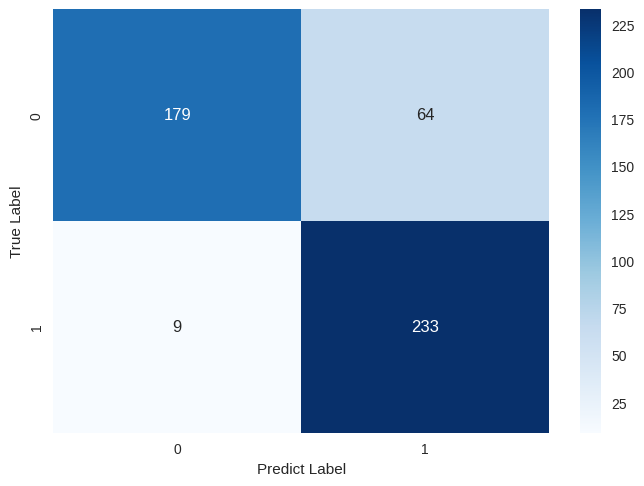


------------ROC AUC Curve---------------------


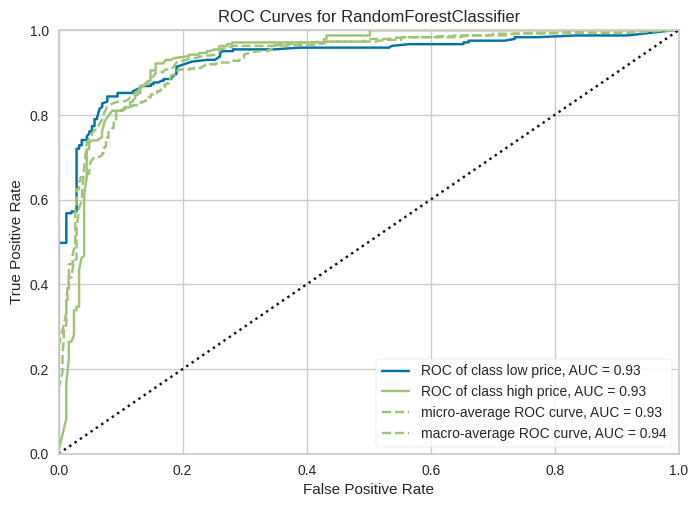

In [ ]:
model_train_all("Random Forest", clf)

### Selected Features

Random Forest
RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=4,
                       max_samples=0.8, n_estimators=20, random_state=0)
Feature Selection Method : Correlation
Features Selected: ['book_cover_price', 'การ์ตูนทั่วไป', 'นิยายวาย Boy Love / Yaoi', 'ไลท์โนเวล', 'Siam Inter Comics']

Training Time: 0.04393434524536133 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.94      0.84      0.89       243
  high price       0.86      0.94      0.90       242

    accuracy                           0.89       485
   macro avg       0.90      0.89      0.89       485
weighted avg       0.90      0.89      0.89       485
 

Accuracy on test:  0.893 

------------Confusion Matrix---------------------


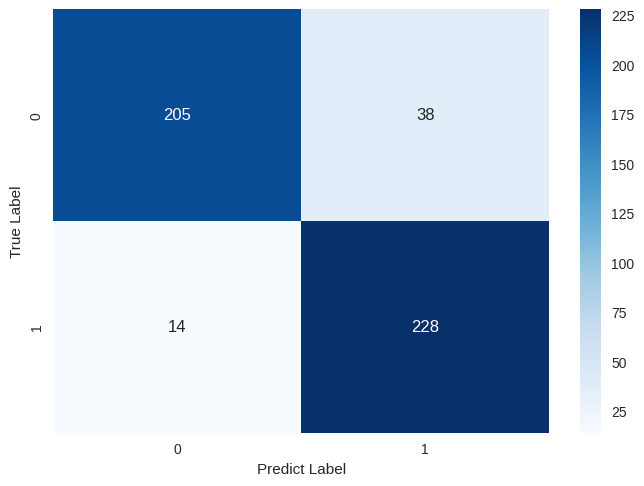


------------ROC AUC Curve---------------------


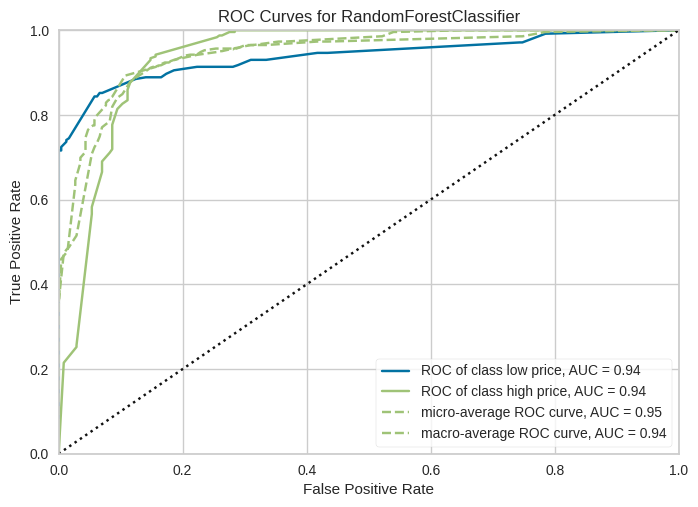

In [ ]:
model_train("Random Forest", selected_features_1, "Correlation", clf)

Random Forest
RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=4,
                       max_samples=0.8, n_estimators=20, random_state=0)
Feature Selection Method : SelectKBest : mutual_info_classif
Features Selected: ['book_cover_price', 'thumbnail_edition', 'days_bf_promotion_end', 'นิยายวาย Boy Love / Yaoi', 'การ์ตูนทั่วไป']

Training Time: 0.04775428771972656 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.96      0.81      0.88       243
  high price       0.84      0.96      0.89       242

    accuracy                           0.89       485
   macro avg       0.90      0.89      0.89       485
weighted avg       0.90      0.89      0.89       485
 

Accuracy on test:  0.887 

------------Confusion Matrix---------------------


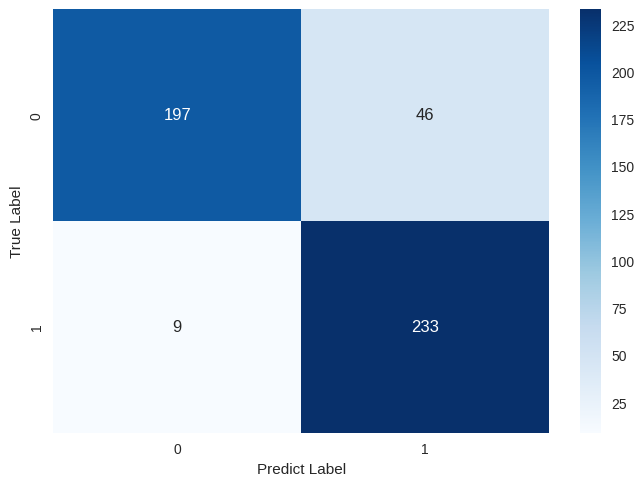


------------ROC AUC Curve---------------------


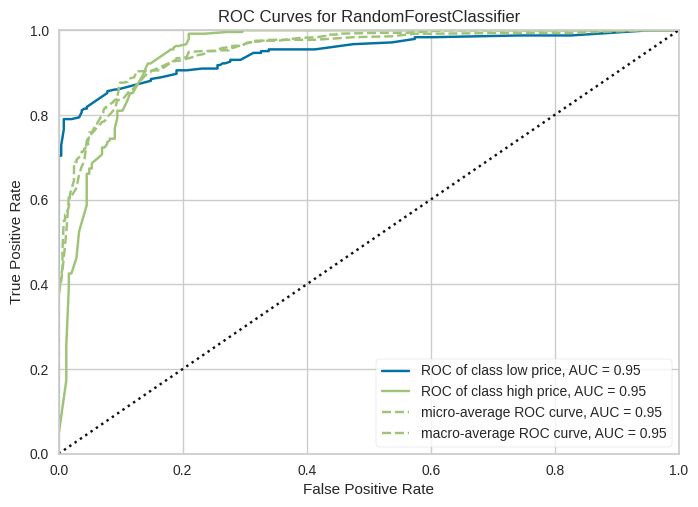

In [ ]:
model_train("Random Forest", selected_features_2, "SelectKBest : mutual_info_classif", clf)

Random Forest
RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=4,
                       max_samples=0.8, n_estimators=20, random_state=0)
Feature Selection Method : SelectfromModel Random Forest
Features Selected: ['adult_only', 'นิยายวาย Boy Love / Yaoi', 'ไลท์โนเวล', 'thumbnail_edition', 'flexible_pricing_enable', 'rating_count', 'การ์ตูนทั่วไป', 'has_series', 'has_promotion', 'book_ratings', 'book_cover_price', 'การ์ตูน Boy Love / Yaoi']

Training Time: 0.04425191879272461 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.96      0.79      0.87       243
  high price       0.82      0.97      0.89       242

    accuracy                           0.88       485
   macro avg       0.89      0.88      0.88       485
weighted avg       0.89      0.88      0.88       485
 

Accuracy on test:  0.88 

------------Confusion Matrix---------------------


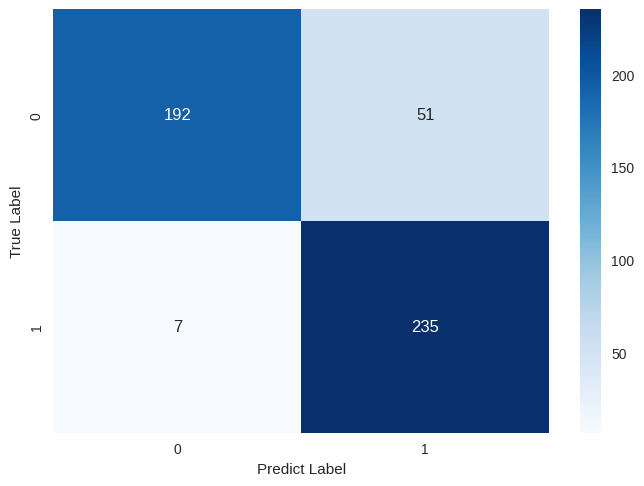


------------ROC AUC Curve---------------------


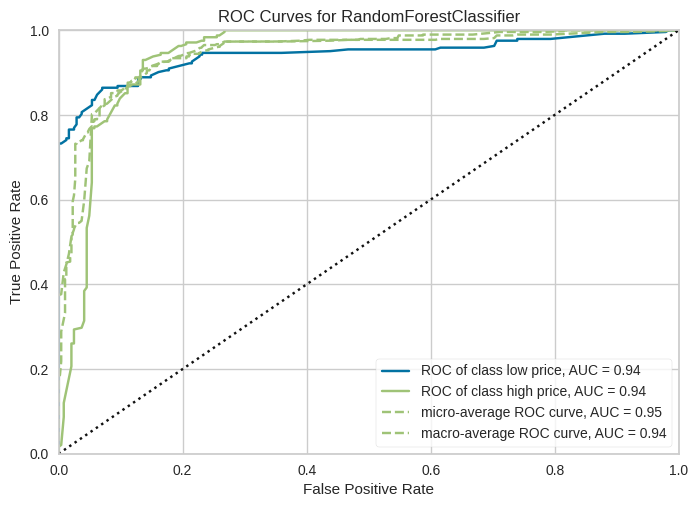

In [ ]:
model_train("Random Forest", selected_features_3, "SelectfromModel Random Forest", clf)

#### GridSearchCV

In [ ]:
# All Features
cv = StratifiedKFold(3)

param_grid ={
    'max_depth' : [5,10,20],
    'n_estimators':[10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
   }

model_rf =RandomForestClassifier(criterion='entropy',ccp_alpha=0.03,max_samples=0.8, random_state=0, )
grid_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv,scoring='accuracy',refit=True,verbose=2)
grid_result_rf =grid_rf.fit(x_train1, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ....max_depth=5, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.1s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.1s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, max_features=auto, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=5, max_features=auto, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=5, max_features=auto, n_e

In [ ]:
print('Best Score: ', grid_result_rf.best_score_)
print('Best Params: ', grid_result_rf.best_params_)

Best Score:  0.8946775589292097
Best Params:  {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}


In [ ]:
grid_rf.best_estimator_

RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=20,
                       max_features='log2', max_samples=0.8, random_state=0)

Random Forest
RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=20,
                       max_features='log2', max_samples=0.8, random_state=0)
Training Time: 0.41320109367370605 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.97      0.81      0.88       243
  high price       0.84      0.97      0.90       242

    accuracy                           0.89       485
   macro avg       0.90      0.89      0.89       485
weighted avg       0.90      0.89      0.89       485
 

Accuracy on test:  0.893 

------------Confusion Matrix---------------------


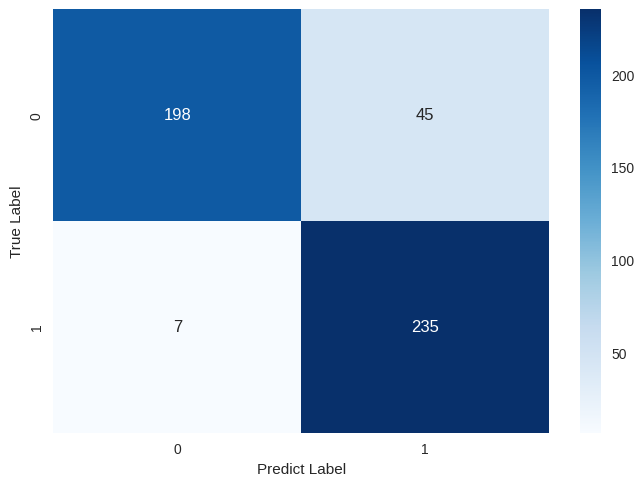


------------ROC AUC Curve---------------------


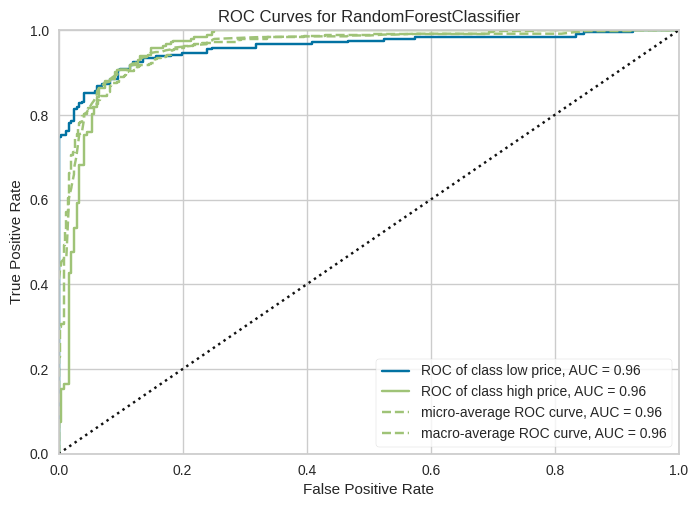

In [ ]:
model_train_all("Random Forest", grid_rf.best_estimator_)

In [ ]:
# Selected Features : SelectKBest
cv = StratifiedKFold(3)

param_grid ={
    'max_depth' : [5,10,20],
    'n_estimators':[10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
   }

model_1 =RandomForestClassifier(criterion='entropy',ccp_alpha=0.03,max_samples=0.8, random_state=0)
grid_1 = GridSearchCV(estimator=model_1, param_grid=param_grid, cv=cv,scoring='accuracy',refit=True,verbose=2)
grid_result_1 =grid_1.fit(x_train1[selected_features_2], y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ....max_depth=5, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.1s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.1s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, max_features=auto, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=5, max_features=auto, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=5, max_features=auto, n_e

In [ ]:
print('Best Score: ', grid_result_1.best_score_)
print('Best Params: ', grid_result_1.best_params_)

Best Score:  0.9062047331489738
Best Params:  {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 10}


In [ ]:
grid_1.best_estimator_

RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=20,
                       max_features='auto', max_samples=0.8, n_estimators=10,
                       random_state=0)

Random Forest
RandomForestClassifier(ccp_alpha=0.03, criterion='entropy', max_depth=20,
                       max_features='auto', max_samples=0.8, n_estimators=10,
                       random_state=0)
Feature Selection Method : SelectKBest mutual_info_classif
Features Selected: ['book_cover_price', 'thumbnail_edition', 'days_bf_promotion_end', 'นิยายวาย Boy Love / Yaoi', 'การ์ตูนทั่วไป']

Training Time: 0.05051302909851074 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.95      0.81      0.88       243
  high price       0.83      0.96      0.89       242

    accuracy                           0.88       485
   macro avg       0.89      0.88      0.88       485
weighted avg       0.89      0.88      0.88       485
 

Accuracy on test:  0.885 

------------Confusion Matrix---------------------


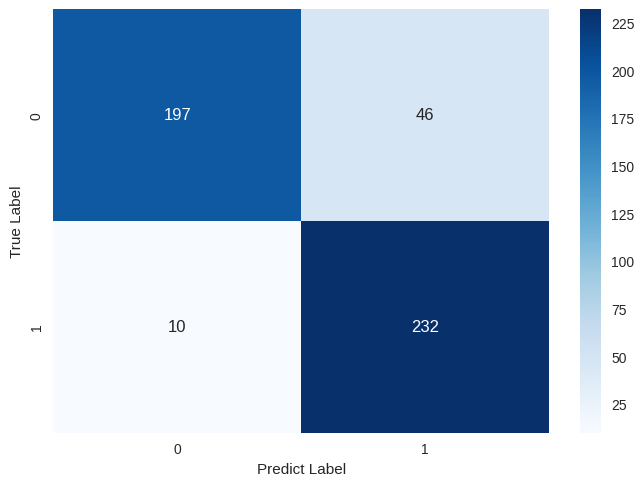


------------ROC AUC Curve---------------------


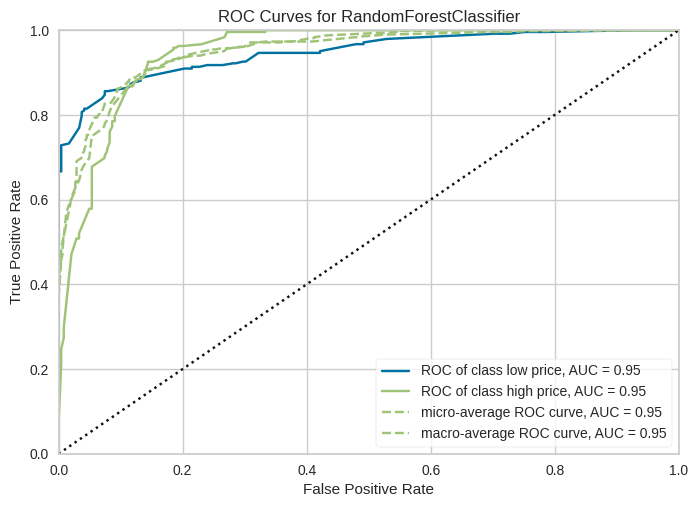

In [ ]:
model_train("Random Forest", selected_features_2 , "SelectKBest mutual_info_classif", grid_1.best_estimator_)

## LightGBM

In [ ]:
max_depth = 4 #@param [4,10,15,25]
n_estimators = 10 #@param [4,10,15,25]

clf2 = lgb.LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.5,
                          max_depth=max_depth,
                          random_state=0,
                          min_split_gain=0.2)

### All features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

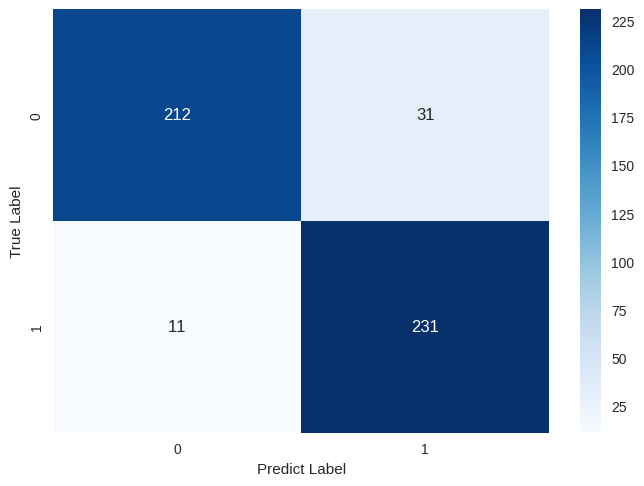


------------ROC AUC Curve---------------------


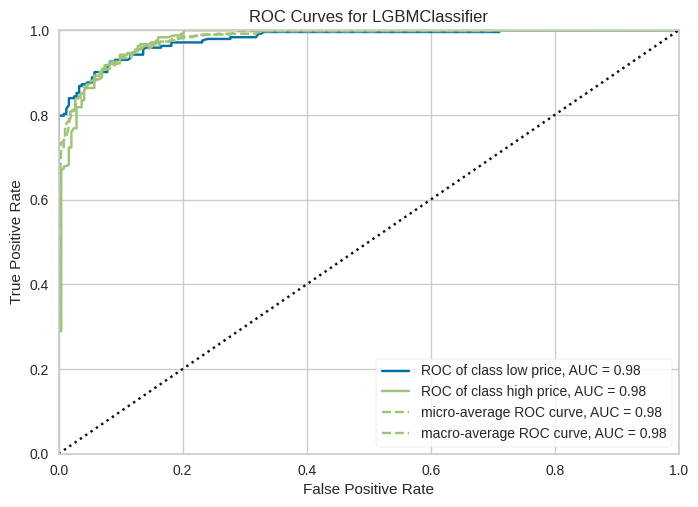

In [ ]:
model_train_all("LightGBM", clf2)

In [ ]:
lgb_start_time = time.time()
clf2.fit(x_train1, y_train)
lgb_end_time = time.time()

y_pred2 =clf2.predict(x_test1)
print(f"Training Time: {(lgb_end_time-lgb_start_time)} seconds")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

Classification Report: 
               precision    recall  f1-score   support

   low price       0.95      0.87      0.91       243
  high price       0.88      0.95      0.92       242

    accuracy                           0.91       485
   macro avg       0.92      0.91      0.91       485
weighted avg       0.92      0.91      0.91       485
 

Accuracy on train:   0.947 

Accuracy on test:  0.913 



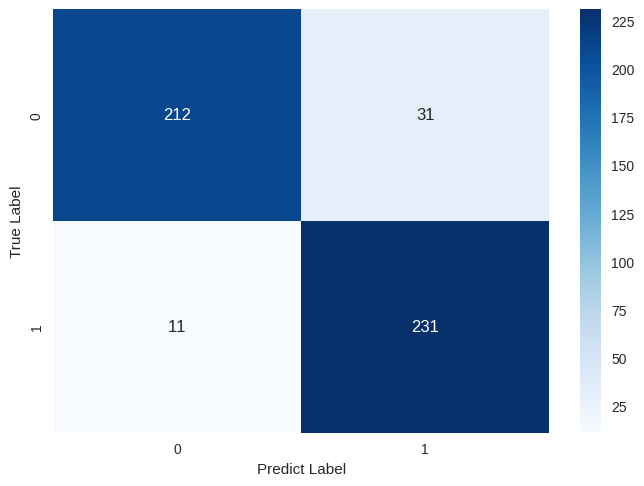

In [ ]:
print("Classification Report: \n", metrics.classification_report(y_test, y_pred2,target_names=['low price','high price']),'\n')
print("Accuracy on train:  ",clf2.score(x_train1,y_train).round(3),'\n')
print("Accuracy on test: ",clf2.score(x_test1,y_test).round(3),'\n')

cf=metrics.confusion_matrix(y_test,y_pred2).round(3)
sns.heatmap(cf,annot=True,cmap='Blues',fmt='d')
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

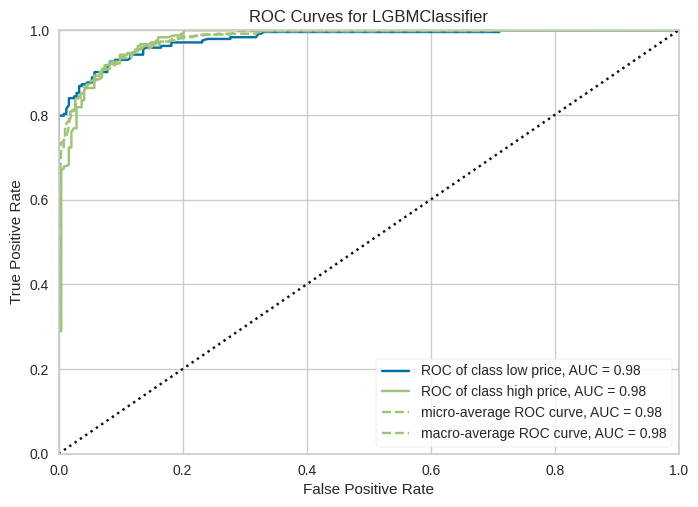

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(clf2, classes=['low price', 'high price'])
visualizer.fit(x_train1, y_train)
visualizer.score(x_test1, y_test)
visualizer.show()

### Selected Features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

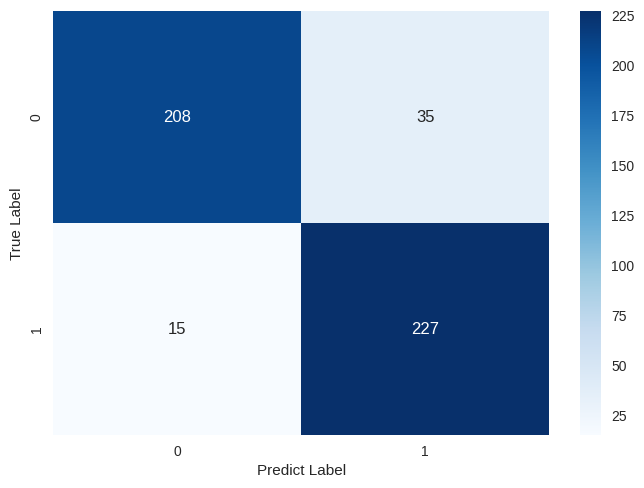


------------ROC AUC Curve---------------------


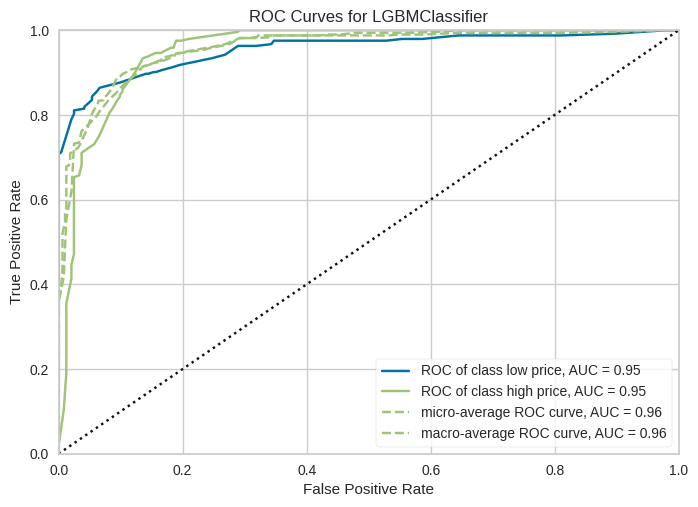

In [ ]:
model_train("LightGBM", selected_features_1, "Correlation", clf2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

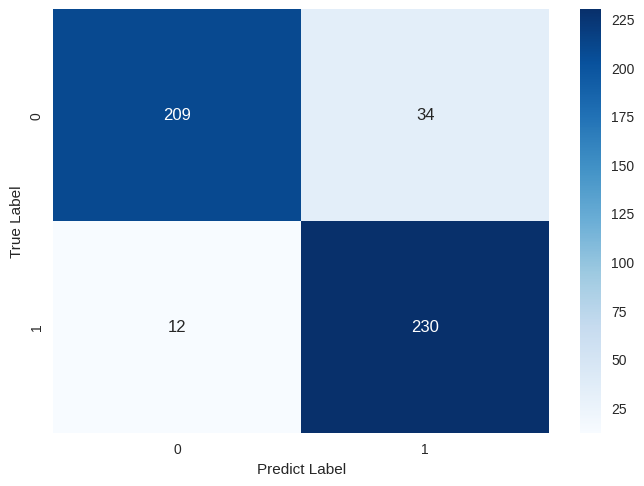


------------ROC AUC Curve---------------------


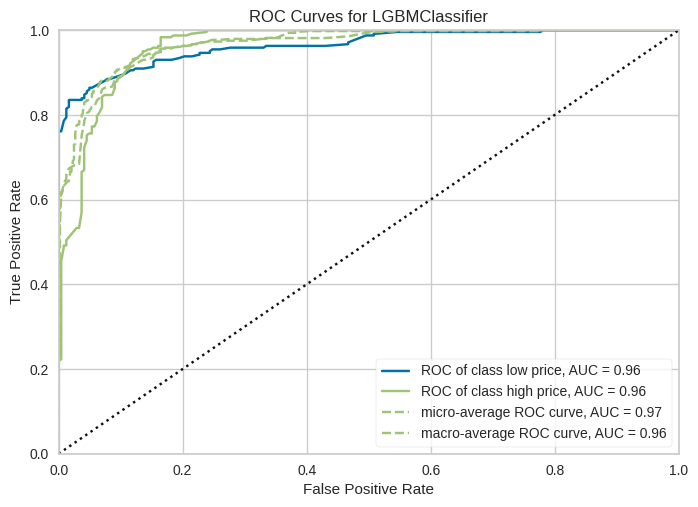

In [ ]:
model_train("LightGBM", selected_features_2, "SelectKBest mutual_info_classif", clf2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

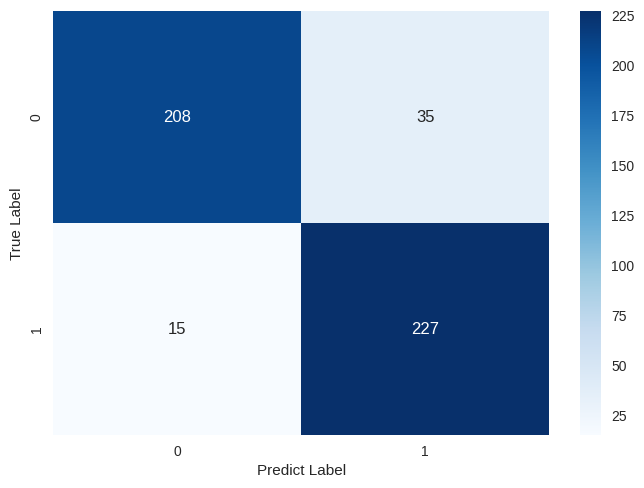


------------ROC AUC Curve---------------------


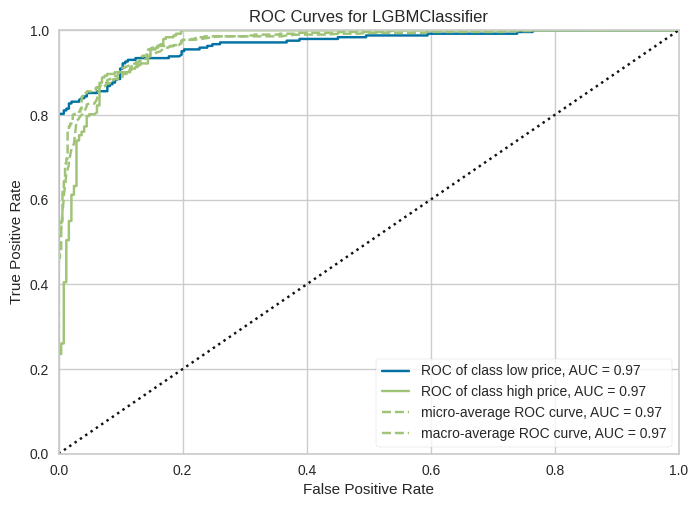

In [ ]:
model_train("LightGBM", selected_features_3, "SelectFromModel Random Forest", clf2)

#### GridSearchCV

In [ ]:
#All features
cv = StratifiedKFold(3)
param_grid = {
  'learning_rate': [0.05, 0.005],
  'n_estimators': [400, 500, 600],
  'num_leaves': [31, 63, 100, 127],
  'boosting_type' : ['gbdt'],
  'max_depth': [-1, 10, 15, 20]
}

model_lgb = lgb.LGBMClassifier(objective="binary", metric="auc", random_state=0)
grid_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid, cv=cv,scoring='accuracy',refit=True,verbose=2)
grid_result_lgb =grid_lgb.fit(x_train1, y_train)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [ ]:
print('Best Score: ', grid_result_lgb.best_score_)
print('Best Params: ', grid_result_lgb.best_params_)

Best Score:  0.9283161201723198
Best Params:  {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 400, 'num_leaves': 63}


In [ ]:
grid_lgb.best_estimator_

LGBMClassifier(learning_rate=0.05, max_depth=15, metric='auc', n_estimators=400,
               num_leaves=63, objective='binary', random_state=0)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

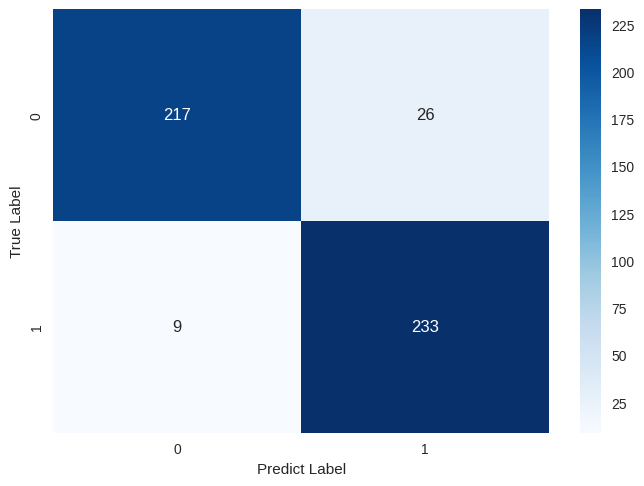


------------ROC AUC Curve---------------------


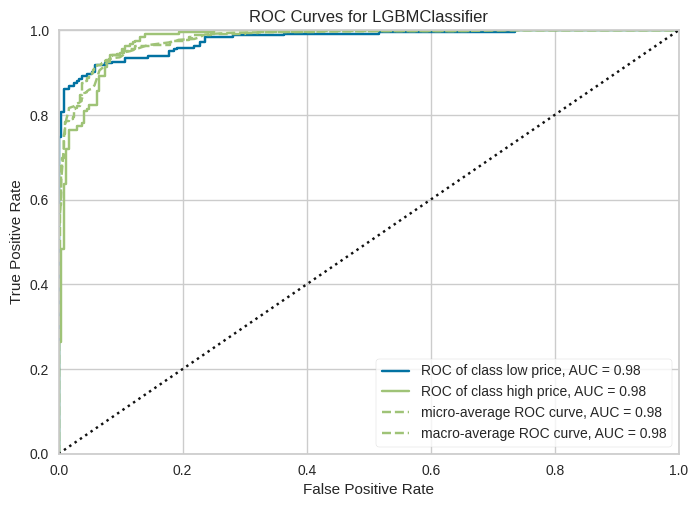

In [ ]:
model_train_all("LightGBM", grid_lgb.best_estimator_)

In [ ]:
#Selected Features : SelectKBest
cv = StratifiedKFold(3)
param_grid = {
  'learning_rate': [0.05, 0.005],
  'n_estimators': [400, 500, 600],
  'num_leaves': [31, 63, 100, 127],
  'boosting_type' : ['gbdt'],
  'max_depth': [-1, 10, 15, 20]
}

model_2 = lgb.LGBMClassifier(objective="binary", metric="auc", random_state=0)
grid_2 = GridSearchCV(estimator=model_2, param_grid=param_grid, cv=cv,scoring='accuracy',refit=True,verbose=2)
grid_result_2 =grid_2.fit(x_train1[selected_features_2], y_train)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [ ]:
print('Best Score: ', grid_result_2.best_score_)
print('Best Params: ', grid_result_2.best_params_)

Best Score:  0.9168195157740279
Best Params:  {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 600, 'num_leaves': 31}


In [ ]:
grid_2.best_estimator_

LGBMClassifier(learning_rate=0.05, max_depth=10, metric='auc', n_estimators=600,
               objective='binary', random_state=0)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 565, number of negative: 565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

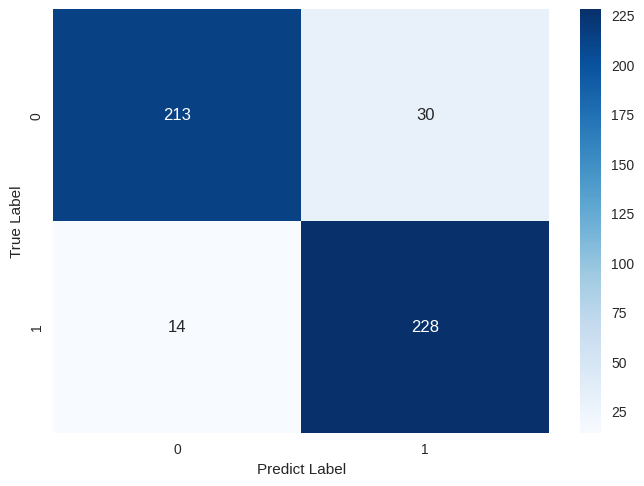


------------ROC AUC Curve---------------------
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


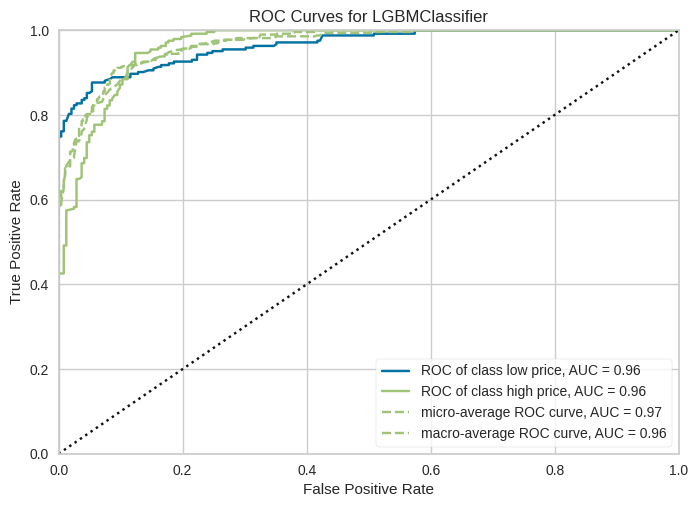

In [ ]:
model_train("LightGBM", selected_features_2, "SelectKBest mutual_info_classif", grid_2.best_estimator_)

## SVC

In [ ]:
C = 1000000 #@param [100,10000,1000000]
kernel = "rbf" #@param ['linear', 'poly', 'rbf']
gamma = "auto"  #@param ['scale', 'auto']
clf3= SVC(
    kernel=kernel,
    C=C,
    gamma=gamma)

### All features

SVC
SVC(C=1000000, gamma='auto')
Training Time: 0.42236328125 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.88      0.84      0.85       243
  high price       0.84      0.88      0.86       242

    accuracy                           0.86       485
   macro avg       0.86      0.86      0.86       485
weighted avg       0.86      0.86      0.86       485
 

Accuracy on test:  0.858 

------------Confusion Matrix---------------------


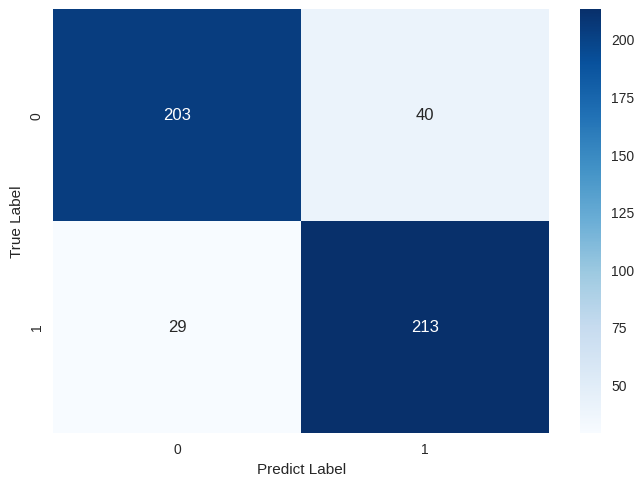


------------ROC AUC Curve---------------------


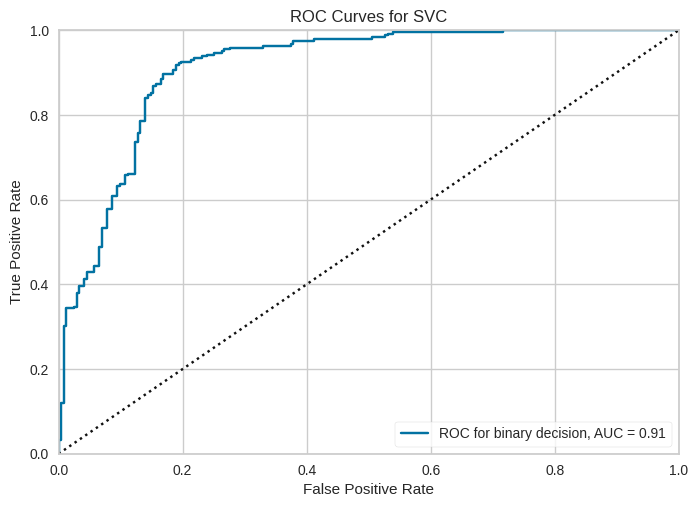

In [ ]:
model_train_all("SVC", clf3)

### Selected Features

SVC
SVC(C=1000000, gamma='auto')
Feature Selection Method : Correlation
Features Selected: ['book_cover_price', 'การ์ตูนทั่วไป', 'นิยายวาย Boy Love / Yaoi', 'ไลท์โนเวล', 'Siam Inter Comics']

Training Time: 6.7178497314453125 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.94      0.85      0.89       243
  high price       0.86      0.94      0.90       242

    accuracy                           0.89       485
   macro avg       0.90      0.89      0.89       485
weighted avg       0.90      0.89      0.89       485
 

Accuracy on test:  0.895 

------------Confusion Matrix---------------------


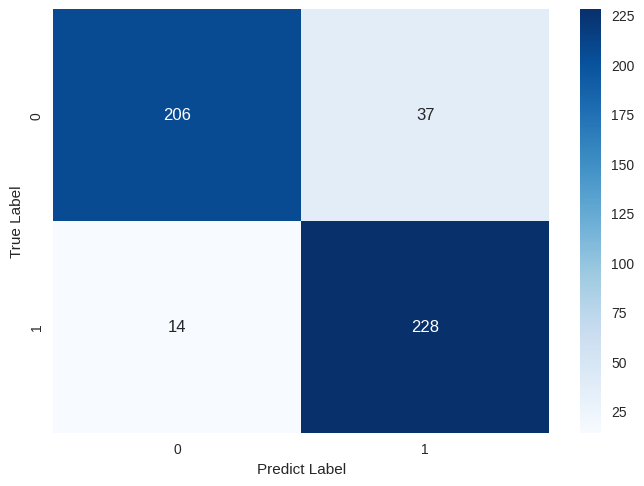


------------ROC AUC Curve---------------------


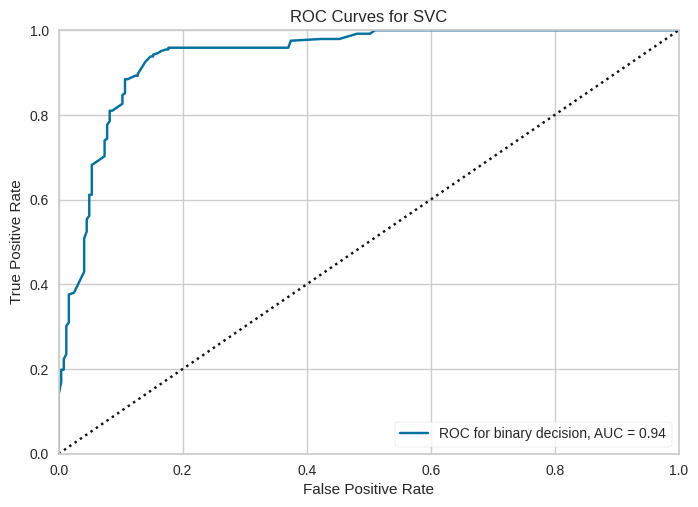

In [ ]:
model_train("SVC", selected_features_1, "Correlation", clf3)

SVC
SVC(C=1000000, gamma='auto')
Feature Selection Method : SelectKBest mutual_info_classif
Features Selected: ['book_cover_price', 'thumbnail_edition', 'days_bf_promotion_end', 'นิยายวาย Boy Love / Yaoi', 'การ์ตูนทั่วไป']

Training Time: 30.80387830734253 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.91      0.82      0.87       243
  high price       0.84      0.92      0.88       242

    accuracy                           0.87       485
   macro avg       0.88      0.87      0.87       485
weighted avg       0.88      0.87      0.87       485
 

Accuracy on test:  0.872 

------------Confusion Matrix---------------------


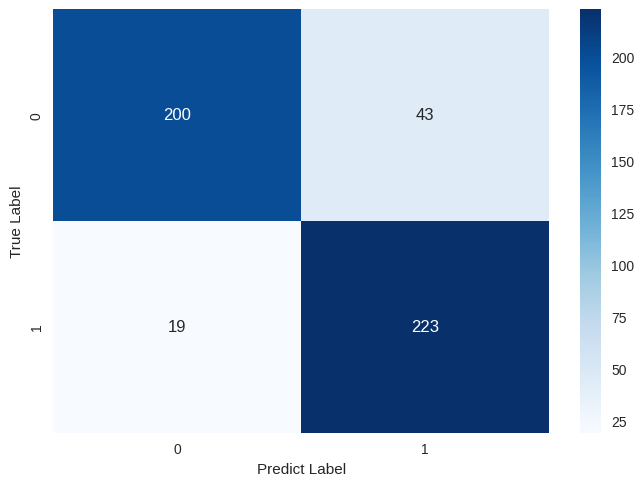


------------ROC AUC Curve---------------------


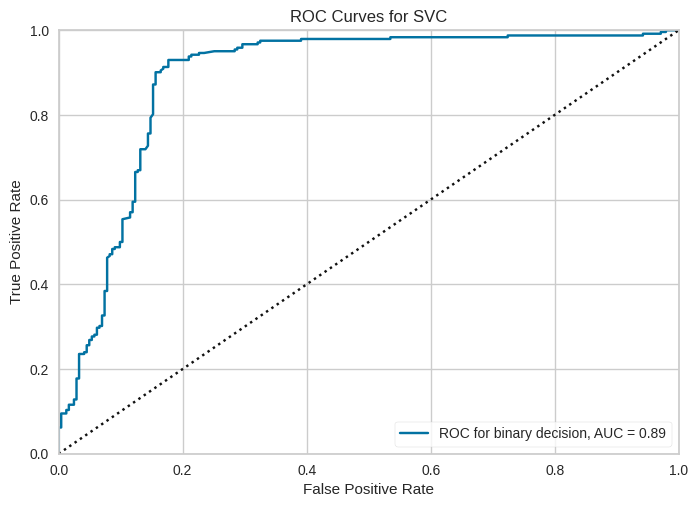

In [ ]:
model_train("SVC", selected_features_2, "SelectKBest mutual_info_classif", clf3)

SVC
SVC(C=1000000, gamma='auto')
Feature Selection Method : SelectFromModel Random Forest
Features Selected: ['adult_only', 'นิยายวาย Boy Love / Yaoi', 'ไลท์โนเวล', 'thumbnail_edition', 'flexible_pricing_enable', 'rating_count', 'การ์ตูนทั่วไป', 'has_series', 'has_promotion', 'book_ratings', 'book_cover_price', 'การ์ตูน Boy Love / Yaoi']

Training Time: 6.714534759521484 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.85      0.81      0.83       243
  high price       0.82      0.85      0.84       242

    accuracy                           0.83       485
   macro avg       0.83      0.83      0.83       485
weighted avg       0.83      0.83      0.83       485
 

Accuracy on test:  0.833 

------------Confusion Matrix---------------------


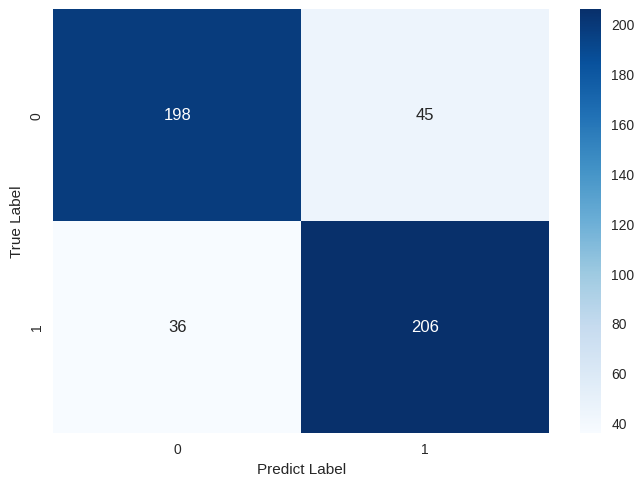


------------ROC AUC Curve---------------------


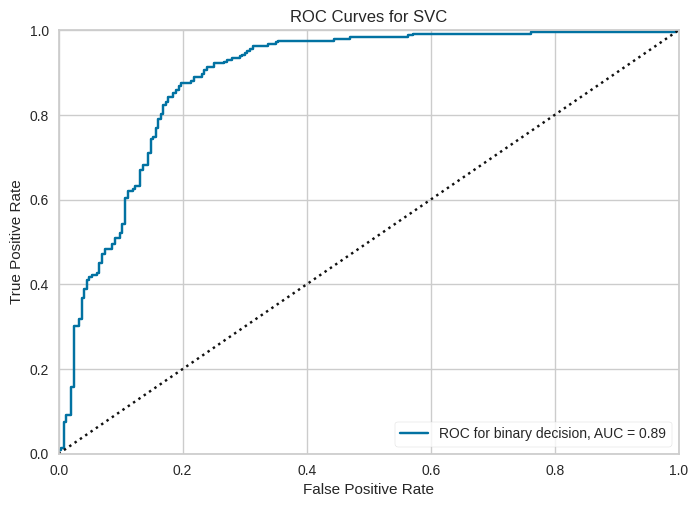

In [ ]:
model_train("SVC", selected_features_3, "SelectFromModel Random Forest", clf3)

#### GridsearchCV

In [ ]:
#All features
cv = StratifiedKFold(3)

param_grid = {
    'kernel' : ['rbf','linear'],
    'C' : [100,10000,1000000],
    'gamma' : [1,0.001,'auto'],
}
model_svc =SVC()
grid_svc = GridSearchCV(estimator=model_svc, param_grid=param_grid, cv=cv,scoring='accuracy',refit=True,verbose=2)
grid_result_svc =grid_svc.fit(x_train1[selected_features_2], y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, k

In [ ]:
print('Best Score: ', grid_result_svc.best_score_)
print('Best Params: ', grid_result_svc.best_params_)

Best Score:  0.9053135052768214
Best Params:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
grid_svc.best_estimator_

SVC(C=100, gamma=0.001)

SVC
SVC(C=100, gamma=0.001)
Training Time: 0.04511308670043945 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.94      0.91      0.93       243
  high price       0.91      0.95      0.93       242

    accuracy                           0.93       485
   macro avg       0.93      0.93      0.93       485
weighted avg       0.93      0.93      0.93       485
 

Accuracy on test:  0.9278 

------------Confusion Matrix---------------------


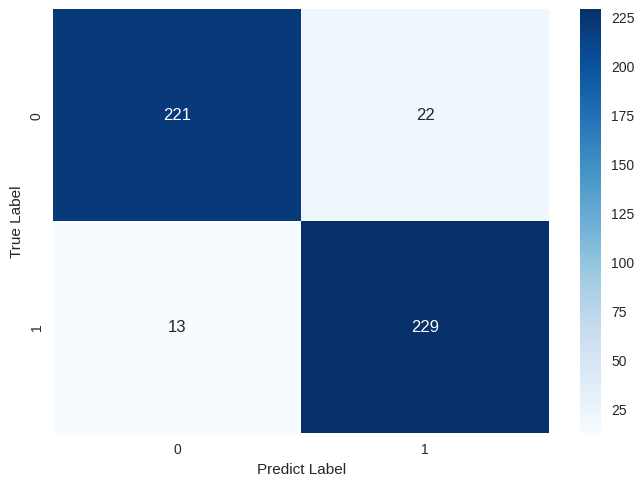


------------ROC AUC Curve---------------------


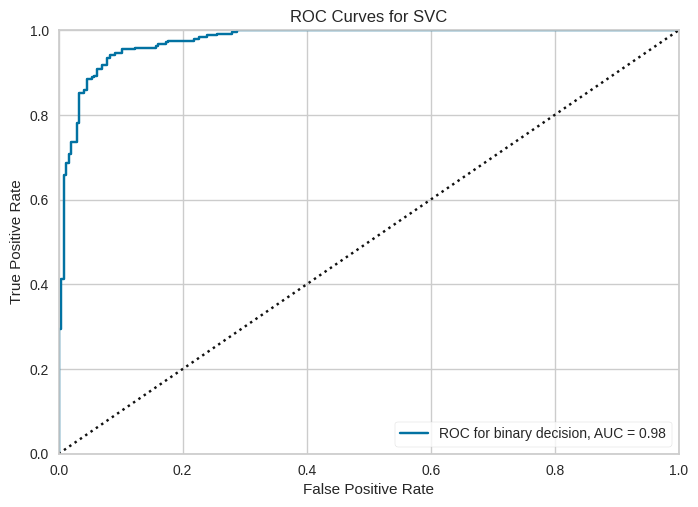

In [ ]:
model_train_all("SVC", grid_svc.best_estimator_)

In [ ]:
#Selected Features : SelectKBest
cv = StratifiedKFold(3)

param_grid = {
    'kernel' : ['rbf','linear'],
    'C' : [100,10000,1000000],
    'gamma' : [1,0.001,'auto'],
}
model_3 =SVC()
grid_3 = GridSearchCV(estimator=model_3, param_grid=param_grid, cv=cv,scoring='accuracy',refit=True,verbose=2)
grid_result_3 =grid_3.fit(x_train1[selected_features_2], y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.2s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.4s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.2s
[CV] END ..................C=100, gamma=0.001, k

In [ ]:
print('Best Score: ', grid_result_3.best_score_)
print('Best Params: ', grid_result_3.best_params_)

Best Score:  0.9053135052768214
Best Params:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
grid_3.best_estimator_

SVC(C=100, gamma=0.001)

SVC
SVC(C=100, gamma=0.001)
Feature Selection Method : SelectKBest mutual_info_classif
Features Selected: ['book_cover_price', 'thumbnail_edition', 'days_bf_promotion_end', 'นิยายวาย Boy Love / Yaoi', 'การ์ตูนทั่วไป']

Training Time: 0.04172706604003906 seconds

Classification Report: 
               precision    recall  f1-score   support

   low price       0.94      0.84      0.88       243
  high price       0.85      0.94      0.89       242

    accuracy                           0.89       485
   macro avg       0.89      0.89      0.89       485
weighted avg       0.89      0.89      0.89       485
 

Accuracy on test:  0.889 

------------Confusion Matrix---------------------


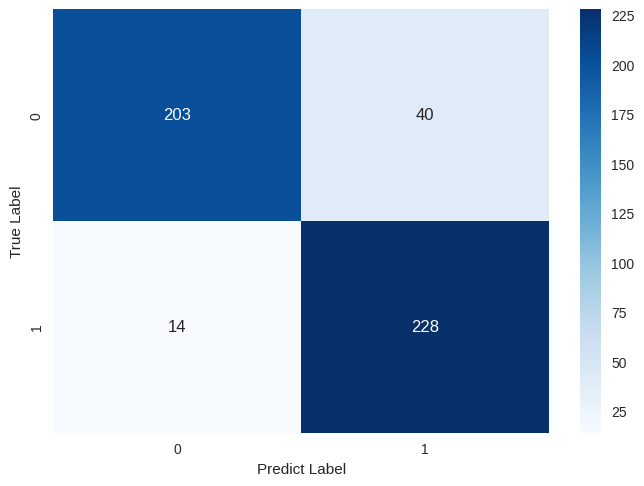


------------ROC AUC Curve---------------------


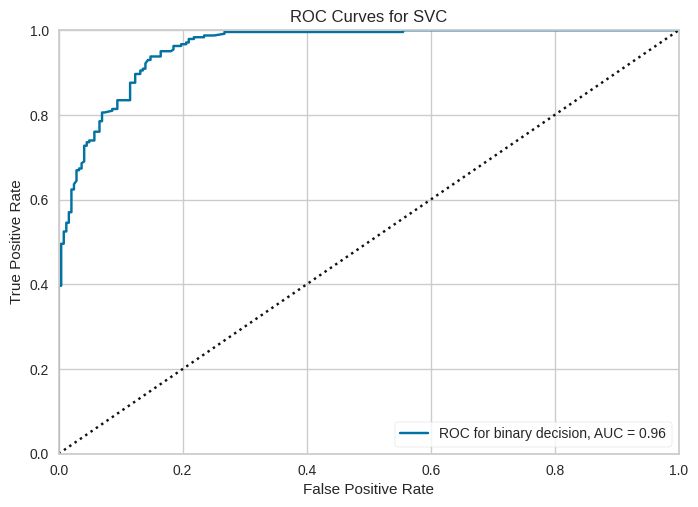

In [ ]:
model_train("SVC", selected_features_2, "SelectKBest mutual_info_classif", grid_3.best_estimator_)

# Summary

Best Model is LightGBM with All features

*   Accurcy = 0.928
*   Precision = 0.93
*   Recall = 0.93
*   AUC Score = 0.98

The AUC Score is high, indicating that this model is able to classify the high and low price well.



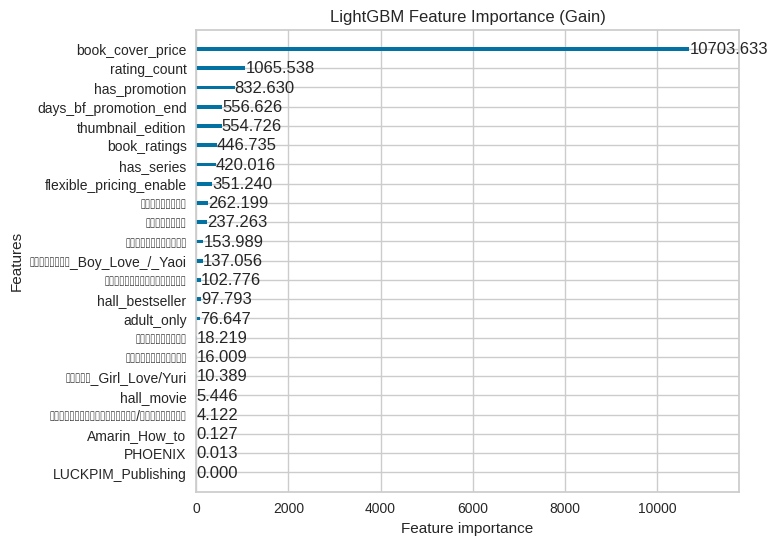

In [ ]:
lgb.plot_importance(grid_lgb.best_estimator_, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()